# 1. Importación de librerias y carga de datos

In [37]:
! pip install folium
! pip install wordcloud

In [1]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#Fetaure Selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#Modelling Algoritm
from sklearn.cluster import KMeans

import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
import requests
import json

from wordcloud import WordCloud

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


#Model Evaluation
#from yellowbrick.cluster import SilhouetteVisualizer

In [66]:
#Load All The Data
olist_orders = pd.read_csv('./input-online/olist_orders_dataset.csv')
olist_products = pd.read_csv('./input-online/olist_products_dataset.csv')
olist_items = pd.read_csv('./input-online/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./input-online/olist_customers_dataset.csv')
olist_payments = pd.read_csv('./input-online/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./input-online/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./input-online/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./input-online/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./input-online/product_category_name_translation.csv')

In [67]:
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')
#all_data = all_data.merge(olist_geolocation, on='seller_zip_code_prefix', how='inner')

In [68]:
#Datos para geovisualización
# Merging orders and order_items
df_orders_items = olist_orders.merge(olist_customers, how='left', on='customer_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['customer_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')

all_data = pd.merge(all_data, df_orders_items[['customer_id','customer_regiao']], on ='customer_id')

In [69]:
#Vea qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [70]:
# Viendo la información en los datos tanto el número de columnas, como la entrada a la memoria
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116581 non-null  object 
 1   customer_id                    116581 non-null  object 
 2   order_status                   116581 non-null  object 
 3   order_purchase_timestamp       116581 non-null  object 
 4   order_approved_at              116567 non-null  object 
 5   order_delivered_carrier_date   115368 non-null  object 
 6   order_delivered_customer_date  114066 non-null  object 
 7   order_estimated_delivery_date  116581 non-null  object 
 8   order_item_id                  116581 non-null  float64
 9   product_id                     116581 non-null  object 
 10  seller_id                      116581 non-null  object 
 11  shipping_limit_date            116581 non-null  object 
 12  price                         

# ** 2. PREPROCESAMIENTO DE DATOS **

En esta etapa, dejaremos los datos fuera del ruido (entradas en blanco, valores atípicos, etc.) para que los datos que se ingresen en el modelo estén limpios y listos para el modelado.

In [71]:
all_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2017-08-28 00:00:00            1.0   
4           2017-08-15 00:00:00            1.0   

                         product_id  ... product_width_cm  \
0  87285b34884572647811a353c7ac498a  ...             13.0   
1  87285b34884572647811a353c7ac498a  ...             13.0   
2  87285b34884572647811a353c7ac498a  ...             13.0   
3  87285b34884572647811a353c7ac498a  ...             13.0   
4  87285b34884572647811a353c7ac498a  ...             13.0   

                 customer_unique_id  customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149      sao paulo   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366      sao paulo   
4  ef0996a1a279c26e7ecbd737be23d235                      2290      sao paulo   

   customer_state seller_zip_code_prefix  seller_city  seller_state  \
0              SP                   9350         maua            SP   
1              SP                   9350         maua            SP   
2              SP                   9350         maua            SP   
3              SP                   9350         maua            SP   
4              SP                   9350         maua            SP   

  product_category_name_english  customer_regiao  
0                    housewares          Sudeste  
1                    housewares          Sudeste  
2                    housewares          Sudeste  
3                    housewares          Sudeste  
4                    housewares          Sudeste  

[5 rows x 41 columns]

## ** 2.1 Manejo variable **

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada y también eliminar la duplicación de los datos que tenemos



In [72]:
all_data['order_purchase_timestamp'].dtype

dtype('O')

In [73]:
# Casteamos las columnas que contienen fechas a datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [74]:
# Ver si hay datos duplicados
print('Duplicados: ',all_data.duplicated().sum())

Duplicados:  0


In [75]:
#Creamos una columna Month_order para la exploración de datos
all_data['Month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')

In [76]:
all_data[['Month_order','order_purchase_timestamp']].head()

Month_order order_purchase_timestamp
0     2017-10      2017-10-02 10:56:33
1     2017-10      2017-10-02 10:56:33
2     2017-10      2017-10-02 10:56:33
3     2017-08      2017-08-15 18:29:31
4     2017-08      2017-08-02 18:24:47

In [77]:
# Nos quedamos con las columnas que van desde 01-2017 hasta 08-2018
# Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 y después del 08-2018
# basado en datos de compra / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [78]:
all_data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18            1.0   
1                    2017-10-18            1.0   
2                    2017-10-18            1.0   
3                    2017-08-28            1.0   
4                    2017-08-15            1.0   

                         product_id  ...                customer_unique_id  \
0  87285b34884572647811a353c7ac498a  ...  7c396fd4830fd04220f754e42b4e5bff   
1  87285b34884572647811a353c7ac498a  ...  7c396fd4830fd04220f754e42b4e5bff   
2  87285b34884572647811a353c7ac498a  ...  7c396fd4830fd04220f754e42b4e5bff   
3  87285b34884572647811a353c7ac498a  ...  3a51803cc0d012c3b5dc8b7528cb05f7   
4  87285b34884572647811a353c7ac498a  ...  ef0996a1a279c26e7ecbd737be23d235   

  customer_zip_code_prefix  customer_city  customer_state  \
0                     3149      sao paulo              SP   
1                     3149      sao paulo              SP   
2                     3149      sao paulo              SP   
3                     3366      sao paulo              SP   
4                     2290      sao paulo              SP   

   seller_zip_code_prefix seller_city  seller_state  \
0                    9350        maua            SP   
1                    9350        maua            SP   
2                    9350        maua            SP   
3                    9350        maua            SP   
4                    9350        maua            SP   

   product_category_name_english customer_regiao  Month_order  
0                     housewares         Sudeste      2017-10  
1                     housewares         Sudeste      2017-10  
2                     housewares         Sudeste      2017-10  
3                     housewares         Sudeste      2017-08  
4                     housewares         Sudeste      2017-08  

[5 rows x 42 columns]

## 2.2 Manejo de valores perdidos

En esta etapa, se hace para eliminar entradas vacías mediante el uso de otras características o el uso de estadísticas (media / mediana)

In [79]:
# Vemos qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.01
order_delivered_customer_date     2.12
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.95
review_comment_message           57.33
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [80]:
# Gestiona entradas vacías en la columna order_approved_at
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('='*50)
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

# tomamos la mediana porque hay quienes aprueban directamente desde el momento en que ordena, algunos son de hasta 60 días
add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at']= all_data['order_approved_at'].replace(np.nan, add_1)

count                    116178
mean     0 days 10:27:08.897923
std      0 days 21:53:11.220121
min             0 days 00:00:00
25%             0 days 00:12:56
50%             0 days 00:20:46
75%      0 days 14:54:27.750000
max            60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:46


In [81]:
# Gestiona entradas vacías en la columna order_approved_at
all_data[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head()

order_purchase_timestamp   order_approved_at order_delivered_carrier_date  \
0      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00   
2      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00   
3      2017-08-15 18:29:31 2017-08-15 20:05:16          2017-08-17 15:28:33   
4      2017-08-02 18:24:47 2017-08-02 18:43:15          2017-08-04 17:35:43   

  order_delivered_customer_date  
0           2017-10-10 21:25:13  
1           2017-10-10 21:25:13  
2           2017-10-10 21:25:13  
3           2017-08-18 14:44:43  
4           2017-08-07 18:30:01

In [82]:
# Gestión de entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('='*50)
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

# Tomamos la mediana porque algunos datos están dentro de las 21 horas del tiempo acordado, algunos hasta 107 días
add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date']= all_data['order_delivered_carrier_date'].replace(np.nan, add_2)

count                    115016
mean     2 days 19:36:08.343613
std      3 days 11:05:42.705027
min         -172 days +18:44:38
25%             0 days 21:12:37
50%      1 days 20:05:56.500000
75%      3 days 14:45:47.750000
max           107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:05:56.500000


In [83]:
# Gestión de entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('='*50)
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

# tomamos la mediana porque hay un tiempo de entrega de -17 días, lo que significa que es atípico, también hay un tiempo de entrega de hasta 205 días
add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date']= all_data['order_delivered_customer_date'].replace(np.nan, add_3)

count                     113726
mean      9 days 05:09:53.148923
std       8 days 15:22:27.173498
min           -17 days +21:41:31
25%              4 days 01:44:35
50%              7 days 01:35:06
75%      11 days 22:31:48.500000
max            205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:35:06


In [84]:
# El número de entradas en blanco en las columnas review_comment_title y review_comment_message es muy grande 
# e imposible de completar.

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [85]:
# Entrega de entrada vacía en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
#Porque solo hay 1, entonces lo dejamos caer
all_data = all_data.dropna()

In [86]:
# Comprueba si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [87]:
# Ajuste el tipo de datos con los datos de entrada
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

## ** 2.3. Extracción de características **

En esta etapa, la adición de nuevas columnas que contienen cálculos de varias columnas para obtener una nueva característica



In [88]:
#Creamos una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta
# que los artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [89]:
#Creamos una columna order_delivery_time para ver cuánto tiempo se requiere el tiempo de envío para cada pedido
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [90]:
#Cree una columna order_time_accuracy para ver si desde el tiempo estimado hasta que algo sea apropiado o tarde
# Si el valor es + positivo, entonces es más rápido hasta que, si es 0, está justo a tiempo, pero si es negativo, llega tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [91]:
#Cree una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [92]:
#Cree una columna review_send_time para averiguar cuánto tiempo se envió la encuesta de satisfacción después de recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [93]:
#Cree una columna review_answer_time para averiguar cuánto tiempo llevará completar una revisión después de
# envió una encuesta de satisfacción del cliente.
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [94]:
# Combine las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
# con una nueva columna, volumen_producto
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

In [95]:
all_data['product_volume'].nunique()

4470

In [96]:
all_data['order_process_time'].mean()

Timedelta('12 days 09:53:11.580178')

## EDA

En esta etapa se lleva a cabo la exploración de datos para obtener información o información que puede ser útil para la empresa.

Text(0, 0.5, 'Product category')

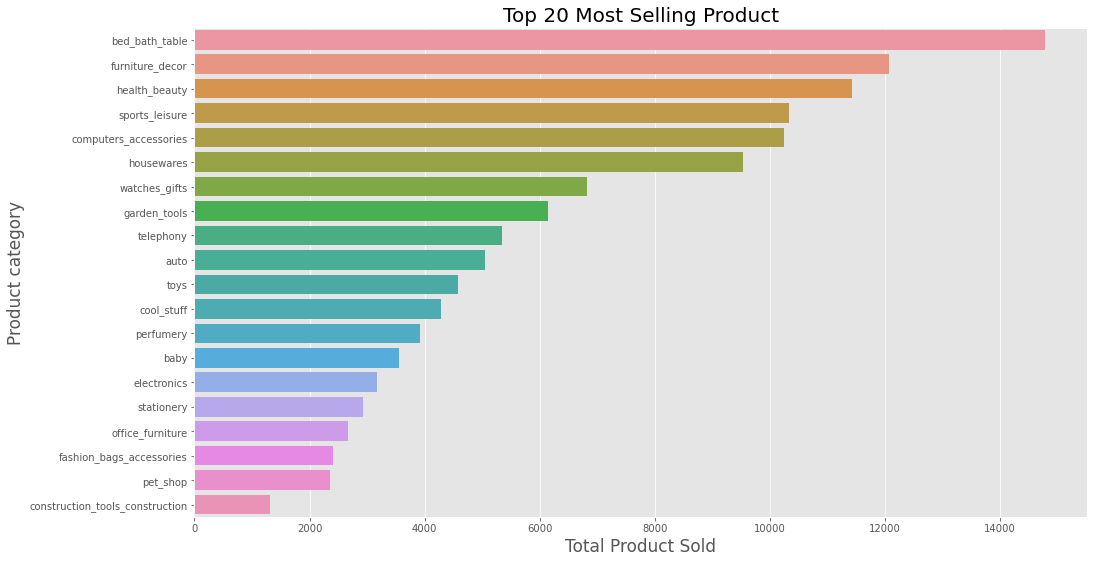

In [97]:
# ¿Qué productos tienen más demanda?
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Most Selling Product',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Product category',fontsize=17)

Text(0, 0.5, 'Customer ID')

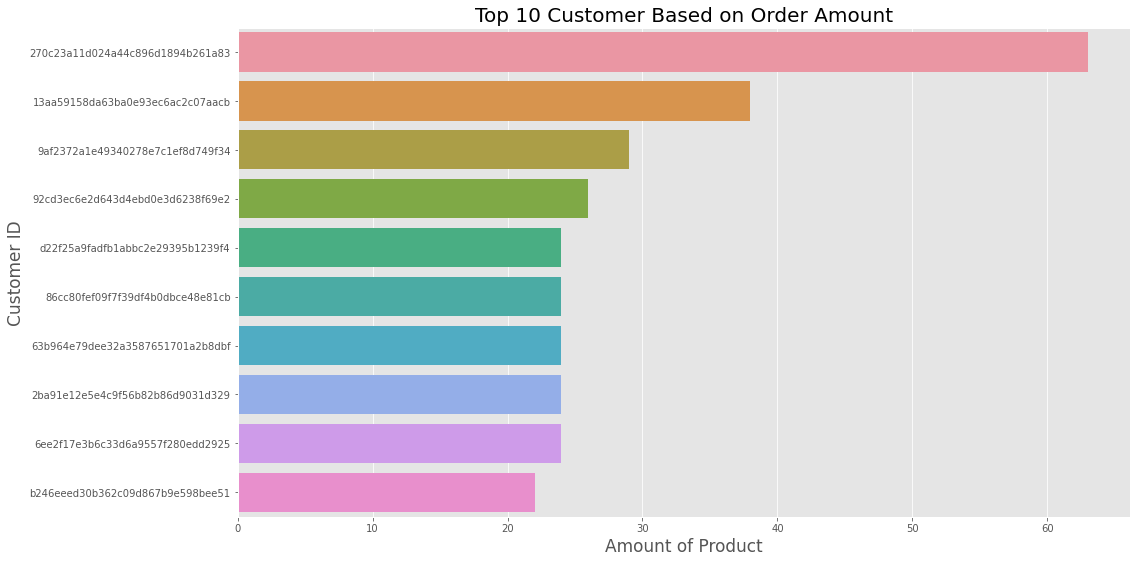

In [98]:
# ¿Quién es el mayor número de compras de clientes en función de la cantidad de pedidos?
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Order Amount',fontsize=20)
plt.xlabel('Amount of Product',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Customer ID')

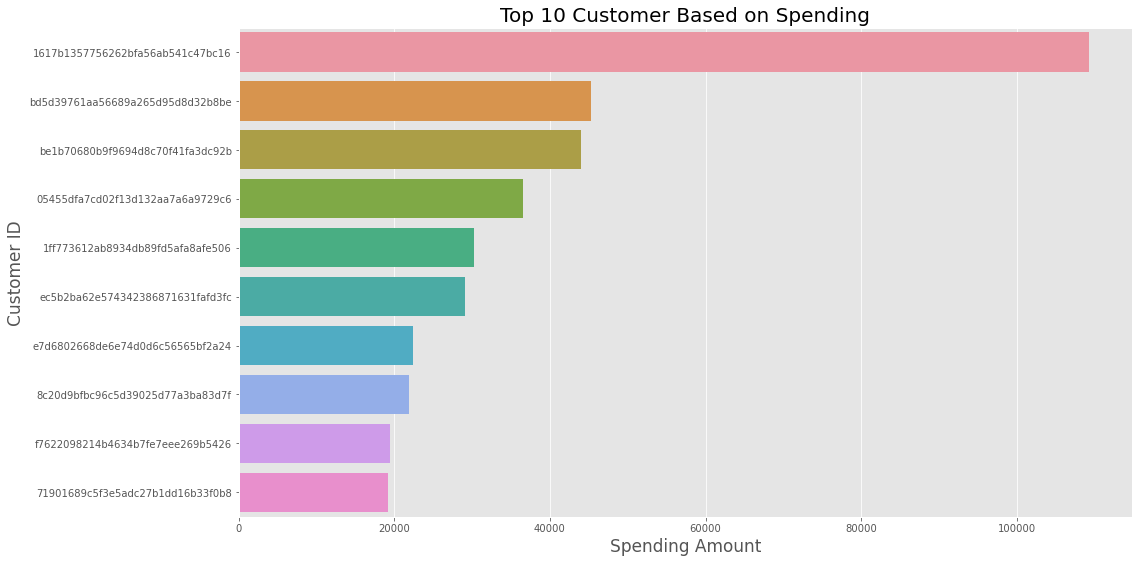

In [99]:
# ¿Quién es el cliente con más gasto en compras por monto?
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Spending',fontsize=20)
plt.xlabel('Spending Amount',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

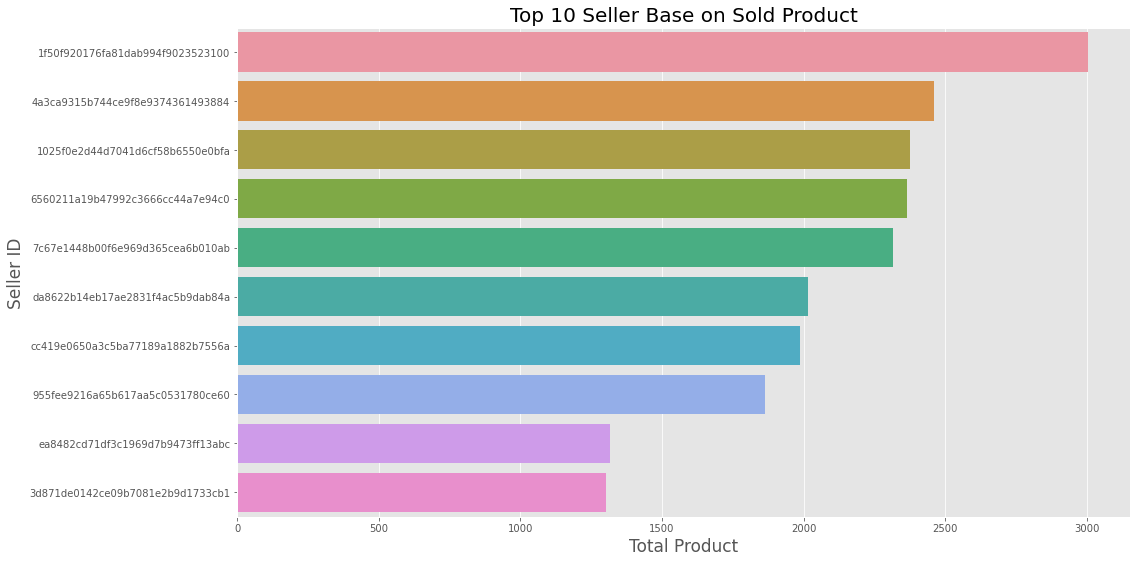

In [100]:
# ¿Qué vendedores venden más?
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Base on Sold Product',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

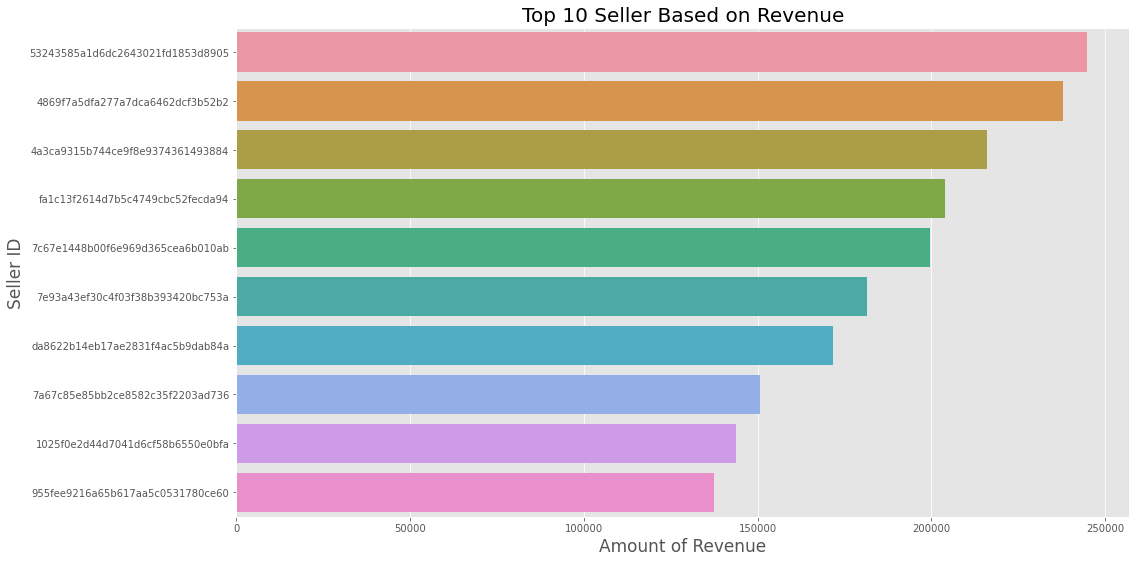

In [101]:
# Vendedor, ¿cuál es el mayor ingreso basado en 'Revenue'?
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Based on Revenue',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

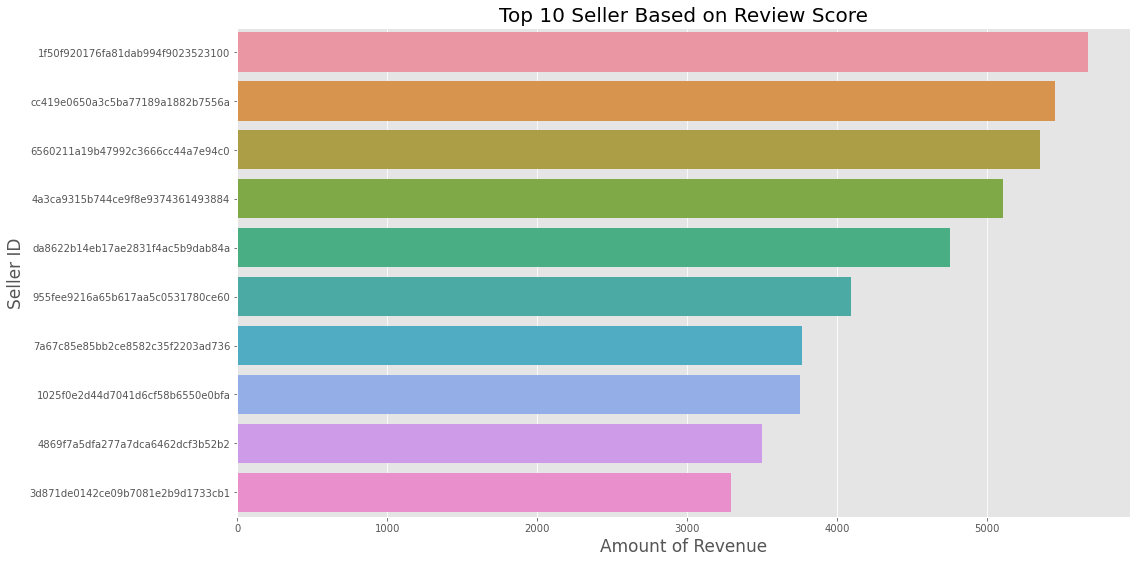

In [102]:
# Vendedor, ¿cuál es el mayor ingreso basado en 'Score' ?
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score)
plt.title('Top 10 Seller Based on Review Score',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

In [103]:
# Distribución del estado del pedido del cliente
round(all_data.order_status.value_counts() / len(all_data),2)

delivered     0.98
shipped       0.01
canceled      0.00
processing    0.00
invoiced      0.00
approved      0.00
Name: order_status, dtype: float64

Text(0, 0.5, 'Time (Day)')

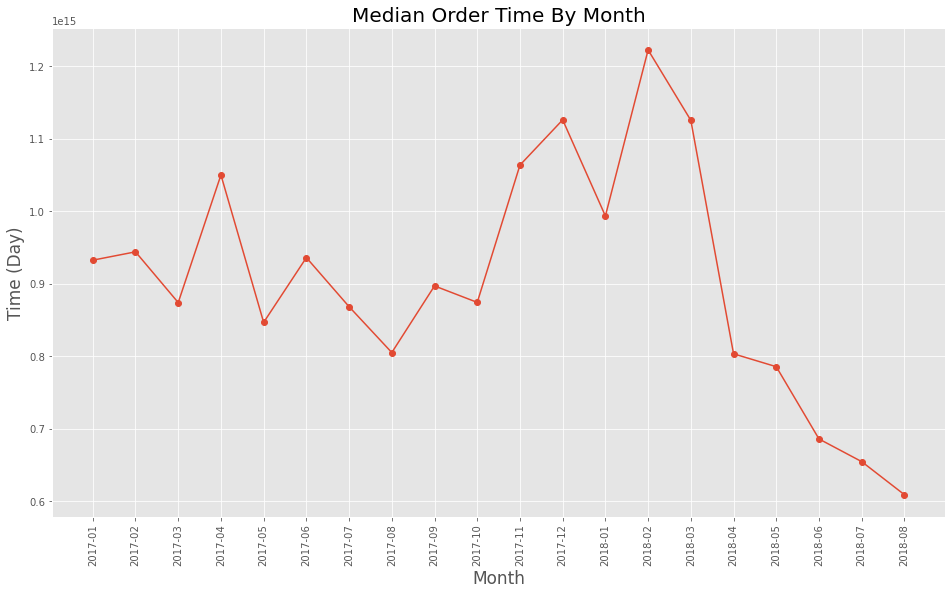

In [104]:
# ¿Cuál es el tiempo promedio desde el pedido hasta el recibo que se necesita en cada pedido mensual?
order_time_by_month = all_data['order_process_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Median Order Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

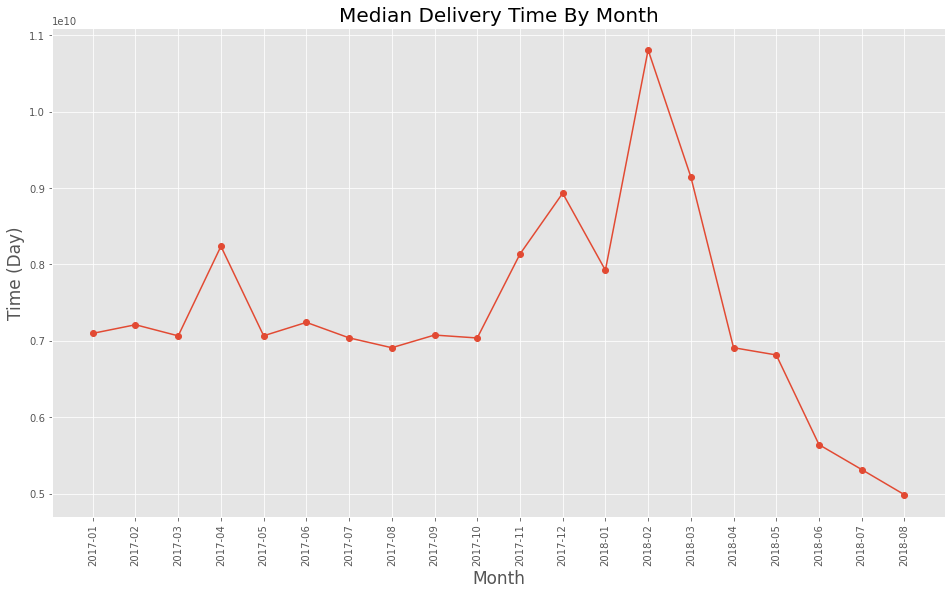

In [105]:
# ¿Cuál es el tiempo de entrega promedio requerido para cada primer pedido?
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta


fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

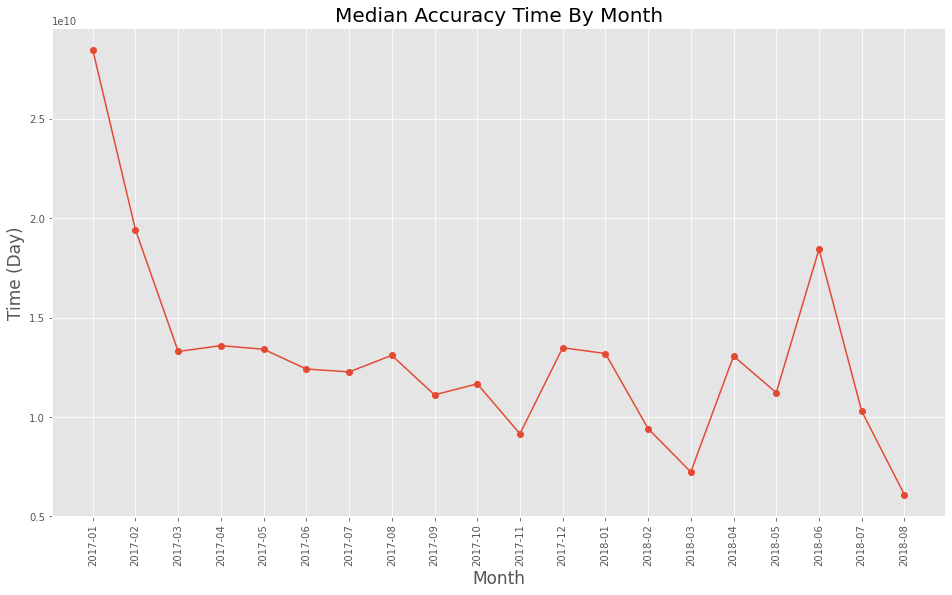

In [106]:
# ¿Cuál es la precisión media del tiempo de los envíos estimados y hasta el cliente en cada pedido por mes?
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Median Accuracy Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Minutes)')

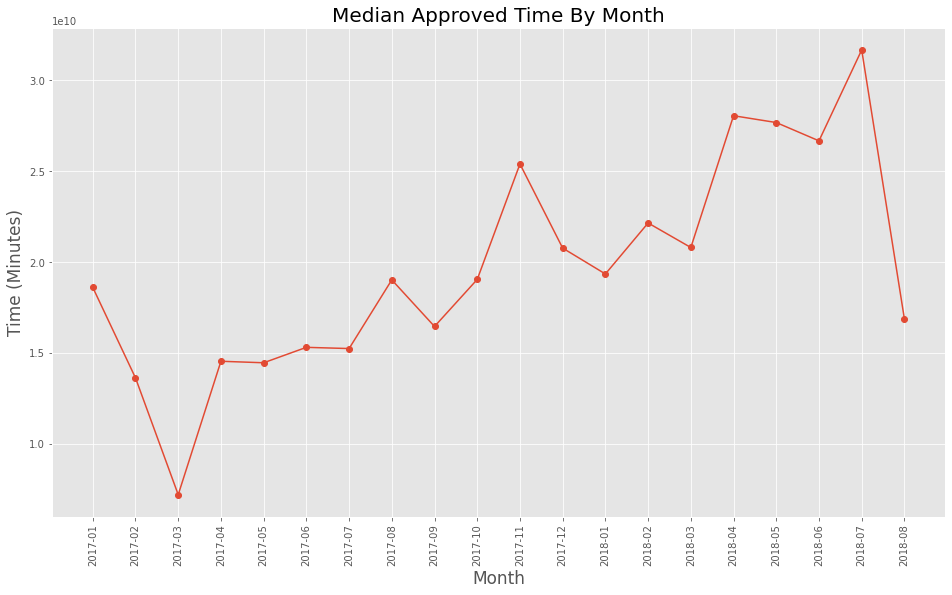

In [107]:
# ¿Cuál es el período de tiempo promedio hasta que se aprueba desde el momento del pedido por mes?
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Median Approved Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Minutes)',fontsize=17)

Text(0, 0.5, 'Product Category')

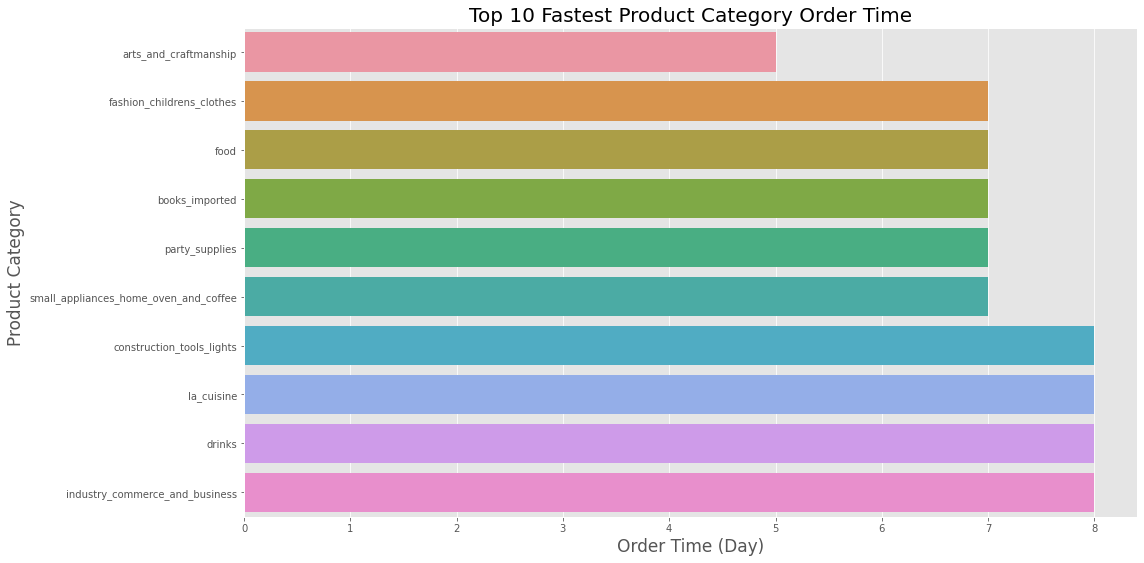

In [108]:
# 10 categorías de productos con el tiempo más rápido desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=True)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Fastest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Product Category')

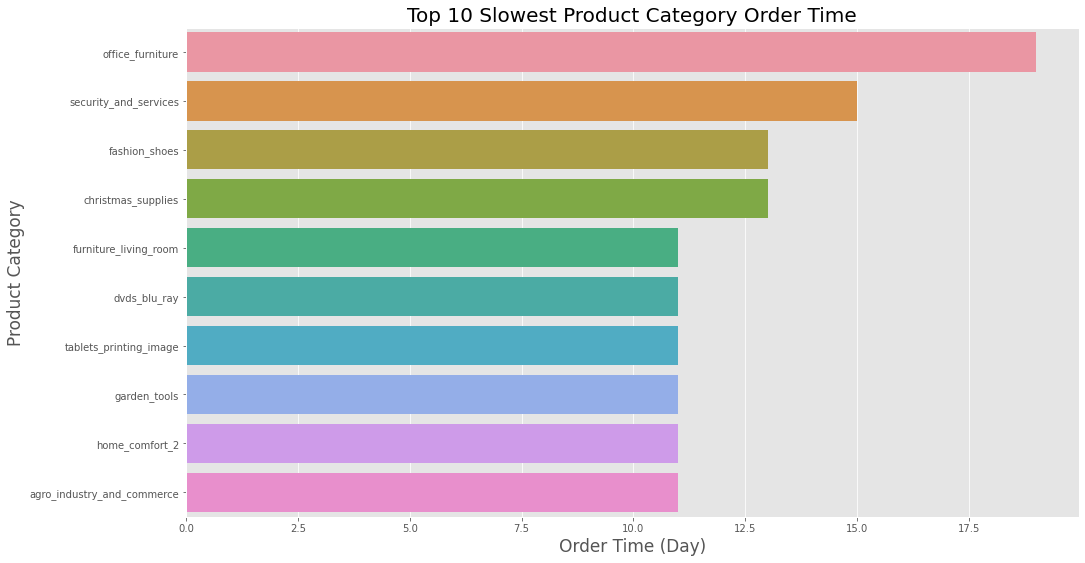

In [109]:
# 10 categorías de productos con el mayor tiempo desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=False)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Slowest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Amount Order')

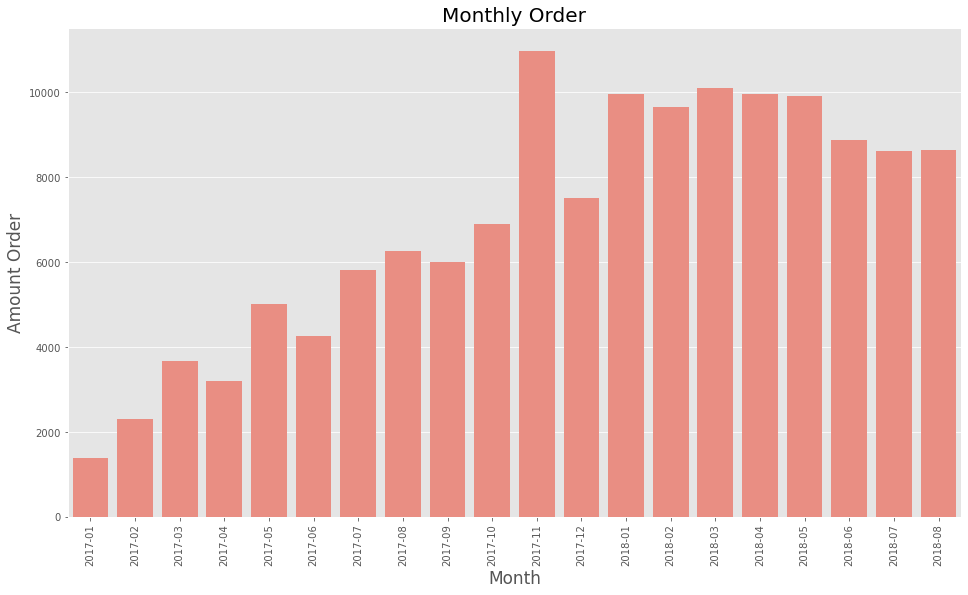

In [110]:
# ¿Cuánto cuesta el pedido cada mes?
order_count_by_month = all_data['order_item_id'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Salmon")
plt.title('Monthly Order',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Order',fontsize=17)

Text(0, 0.5, 'Amount Revenue')

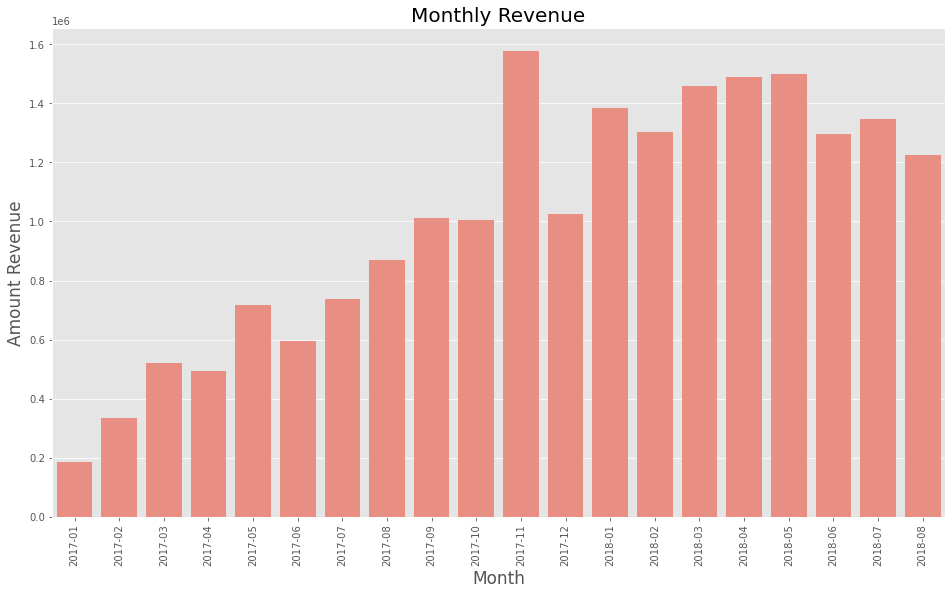

In [111]:
# ¿Cuánto es el ingreso mensual?
revenue_count_by_month = all_data['payment_value'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index, color="Salmon")
plt.title('Monthly Revenue',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Revenue',fontsize=17)

Text(0, 0.5, 'Amount of User')

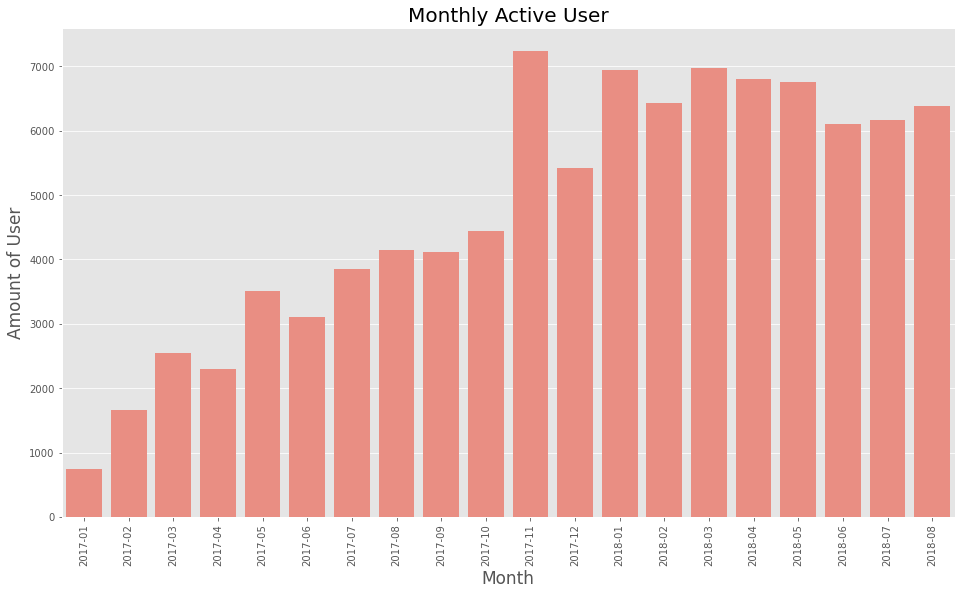

In [112]:
# ¿Cómo son los clientes activos cada mes?
customer_active_by_month = all_data.groupby('Month_order')['customer_unique_id'].nunique().reset_index()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['Month_order'], color="Salmon")
plt.title('Monthly Active User',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount of User',fontsize=17)

### Geovisualización 

Text(0, 0.5, 'City')

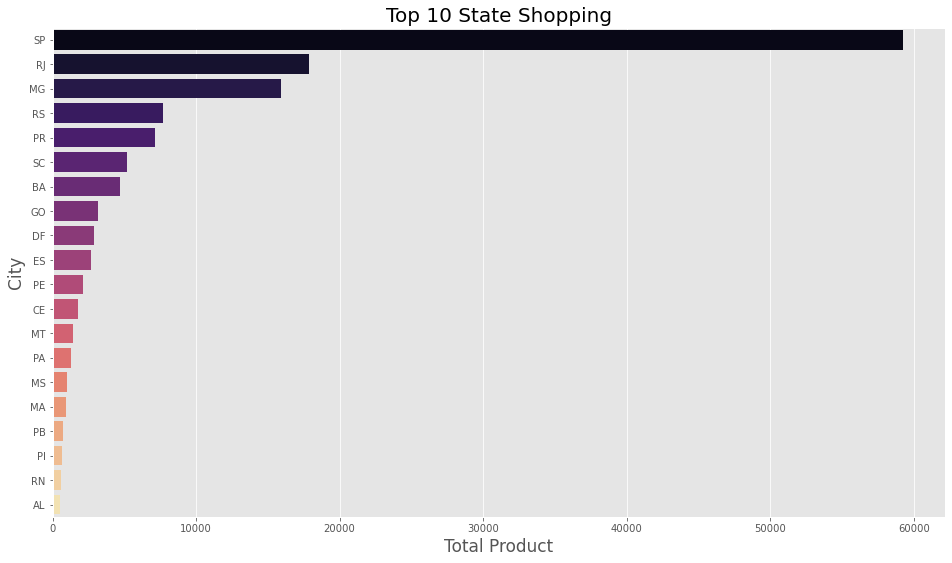

In [113]:
top_10_state = all_data['order_item_id'].groupby(all_data['customer_state']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué estados compran más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_state.index,x=top_10_state.values, palette='magma')
plt.title('Top 10 State Shopping',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

Text(0, 0.5, 'City')

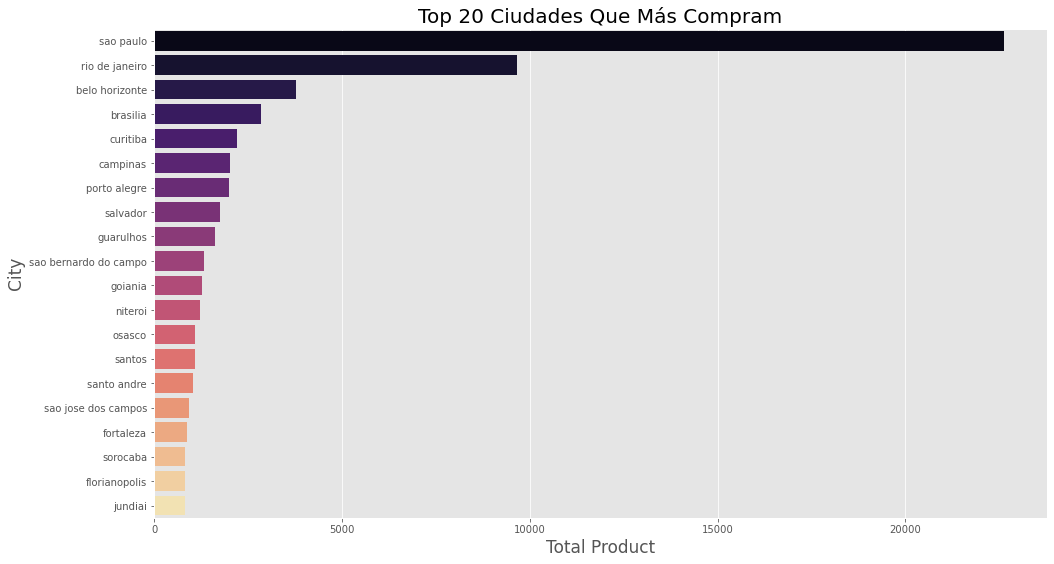

In [114]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué ciudad compra más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values, palette='magma')
plt.title('Top 20 Ciudades Que Más Compram',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

seller_city
sao paulo                35086
ibitinga                 10234
sao jose do rio preto     3780
santo andre               3728
curitiba                  3599
rio de janeiro            2922
maringa                   2867
belo horizonte            2850
ribeirao preto            2745
itaquaquecetuba           2653
guarulhos                 2530
piracicaba                2446
campinas                  1666
salto                     1602
praia grande              1505
sao bernardo do campo     1374
campo limpo paulista      1353
sao jose dos campos       1308
guariba                   1223
jacarei                   1059
Name: order_item_id, dtype: int64


Text(0, 0.5, 'City')

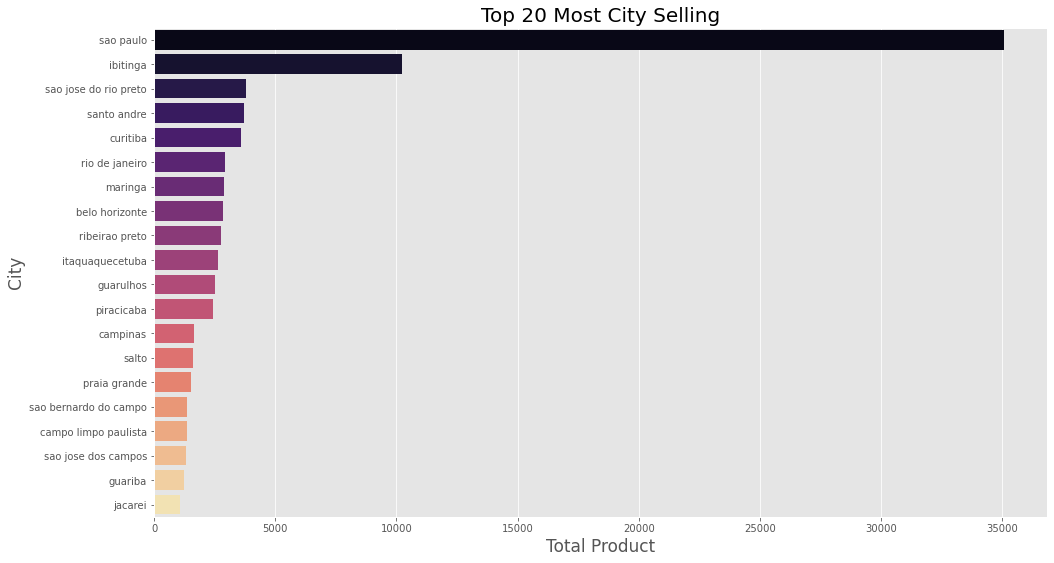

In [115]:
top_20_city_selling = all_data['order_item_id'].groupby(all_data['seller_city']).sum().sort_values(ascending=False)[:20]
print(top_20_city_selling)

# ¿Qué ciudad vende más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_selling.index,x=top_20_city_selling.values, palette='magma')
plt.title('Top 20 Most City Selling',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

In [116]:
all_data['seller_state'].value_counts(normalize=True)

SP    0.713498
MG    0.077984
PR    0.077278
RJ    0.042189
SC    0.036466
RS    0.019244
DF    0.008030
BA    0.006016
GO    0.004648
PE    0.004002
MA    0.003529
ES    0.003245
MT    0.001265
CE    0.000878
MS    0.000491
RN    0.000482
PB    0.000353
RO    0.000120
PI    0.000103
SE    0.000086
PA    0.000069
AM    0.000026
Name: seller_state, dtype: float64

Text(0, 0.5, 'City')

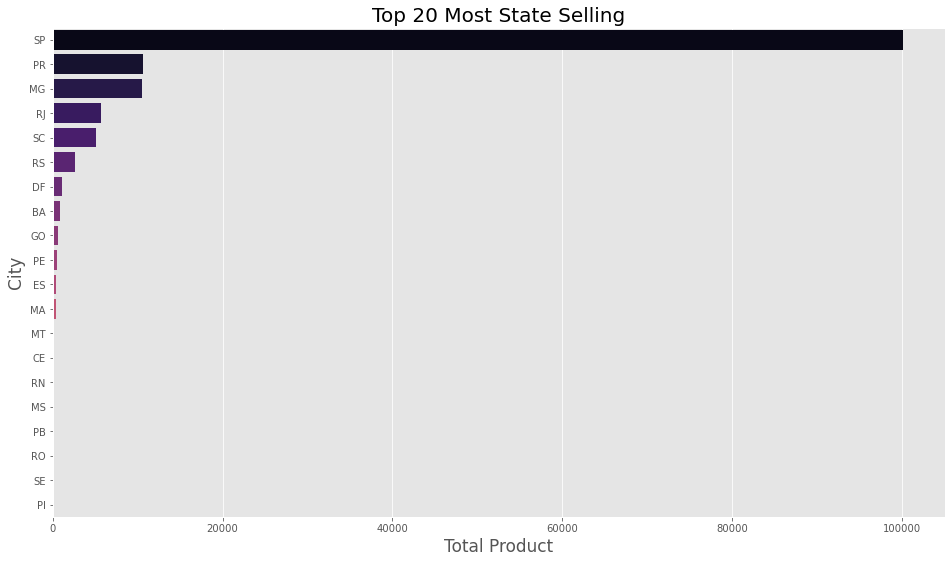

In [117]:
top_10_state_selling = all_data['order_item_id'].groupby(all_data['seller_state']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué ciudad vende más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_state_selling.index,x=top_10_state_selling.values, palette='magma')
plt.title('Top 20 Most State Selling',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

In [118]:
# Donde están los clientes?
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_items.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)


# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles="OpenStreetMap"
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13,
).add_to(map1)

map1

In [119]:
geo = geo_prep.copy()
geo.columns = ['zip_code','geolocation_lat','geolocation_lng','geolocation_city','geolocation_state']
geo

zip_code  geolocation_lat  geolocation_lng geolocation_city  \
0            1037       -23.545621       -46.639292        sao paulo   
1            1046       -23.546081       -46.644820        sao paulo   
2            1046       -23.546129       -46.642951        sao paulo   
3            1041       -23.544392       -46.639499        sao paulo   
4            1035       -23.541578       -46.641607        sao paulo   
...           ...              ...              ...              ...   
1000158     99950       -28.068639       -52.010705         tapejara   
1000159     99900       -27.877125       -52.224882   getulio vargas   
1000160     99950       -28.071855       -52.014716         tapejara   
1000161     99980       -28.388932       -51.846871  david canabarro   
1000162     99950       -28.070104       -52.018658         tapejara   

        geolocation_state  
0                      SP  
1                      SP  
2                      SP  
3                      SP  
4                      SP  
...                   ...  
1000158                RS  
1000159                RS  
1000160                RS  
1000161                RS  
1000162                RS  

[1000121 rows x 5 columns]

In [120]:
sellers = olist_sellers[['seller_id','seller_zip_code_prefix']]
sellers.columns=['seller_id','zip_code']
sellers

seller_id  zip_code
0     3442f8959a84dea7ee197c632cb2df15     13023
1     d1b65fc7debc3361ea86b5f14c68d2e2     13844
2     ce3ad9de960102d0677a81f5d0bb7b2d     20031
3     c0f3eea2e14555b6faeea3dd58c1b1c3      4195
4     51a04a8a6bdcb23deccc82b0b80742cf     12914
...                                ...       ...
3090  98dddbc4601dd4443ca174359b237166     87111
3091  f8201cab383e484733266d1906e2fdfa     88137
3092  74871d19219c7d518d0090283e03c137      4650
3093  e603cf3fec55f8697c9059638d6c8eb5     96080
3094  9e25199f6ef7e7c347120ff175652c3b     12051

[3095 rows x 2 columns]

In [121]:
sellers_geo = pd.merge(geo, sellers[['seller_id','zip_code']], on='zip_code')
sellers_geo = sellers_geo.drop_duplicates(subset=['seller_id'])

In [122]:
sellers_geo

zip_code  geolocation_lat  geolocation_lng geolocation_city  \
0           1041       -23.544392       -46.639499        sao paulo   
25          1035       -23.541578       -46.641607        sao paulo   
64          1039       -23.541883       -46.639919        sao paulo   
83          1042       -23.544874       -46.640303        sao paulo   
123         1040       -23.540317       -46.637355        sao paulo   
...          ...              ...              ...              ...   
433805     99500       -28.289446       -52.794123        carazinho   
433806     99500       -28.289446       -52.794123        carazinho   
434719     99670       -27.783656       -52.807832       ronda alta   
434758     99700       -27.634768       -52.280294          erechim   
435072     99730       -27.729373       -52.537491        jacutinga   

       geolocation_state                         seller_id  
0                     SP  e5cbe890e679490127e9a390b46bbd20  
25                    SP  1d503743d2526f03f0c2c89540ee008c  
64                    SP  2d34636518ba88f5349b732fcf8ba2e4  
83                    SP  b6c6854d4d92a5f6f46be8869da3fa1a  
123                   SP  784ba75dd9d20200c4caed3d7a77141a  
...                  ...                               ...  
433805                RS  447d377bdb757058acb569025ee18a93  
433806                RS  b1a81260566c1bac3114a6d124413f27  
434719                RS  4fae87d32467e18eb46e4a76a0a0b9ce  
434758                RS  968ee78631915a63fef426d6733d7422  
435072                RS  d1c7fa84e48cfa21a0e595167c1c500e  

[3088 rows x 6 columns]

In [123]:
# Donde están los vendedores?
# Grouping geolocation data for plotting a heatmap
heat_data = sellers_geo.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)


# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles="OpenStreetMap"
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13,
).add_to(map1)

map1

### Envio

In [124]:
all_data['freight_value'].mean()

20.062862442016087

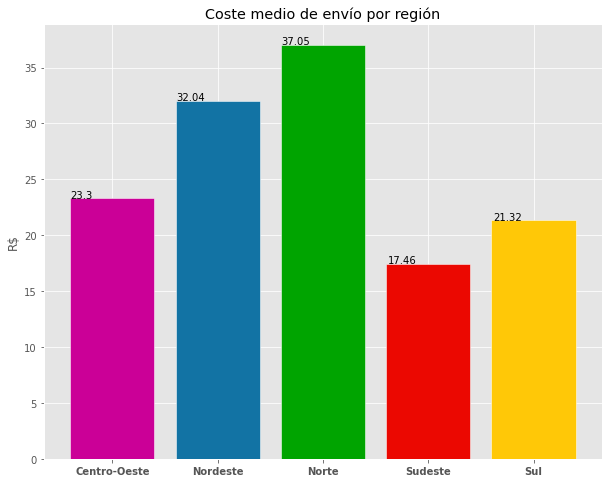

In [125]:
colores = ['#cb0097','#1273a4','#00a400','#eb0801','#ffc807']

plt.figure(figsize=(10,8))
ax = (all_data.groupby('customer_regiao')['freight_value'].mean().round(2)).plot(kind = 'bar', width=0.8,color=colores,edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
   
plt.xlabel('')
plt.ylabel('R$')
plt.title('Coste medio de envío por región')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

#### Order status

In [126]:
all_data['order_status'].value_counts()                      

delivered     113732
shipped         1213
canceled         538
processing       360
invoiced         345
approved           3
Name: order_status, dtype: int64

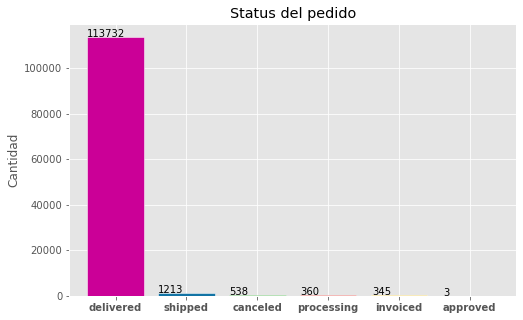

In [127]:
plt.figure(figsize=(8,5))
ax = all_data['order_status'].value_counts().plot(kind = 'bar', width=0.8,color=colores,edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
   
plt.xlabel('')
plt.ylabel('Cantidad')
plt.title('Status del pedido')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

### Payment Type

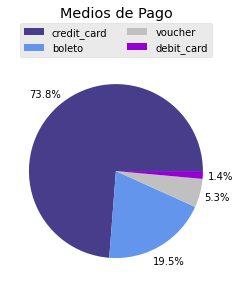

In [128]:
size_of_groups = all_data['payment_type'].value_counts()
labels = all_data['payment_type'].value_counts().index
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
plt.pie(size_of_groups, colors=colors, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='lower center', bbox_to_anchor=(.5,1),ncol=2, fancybox=True)

plt.title('Medios de Pago', pad=45)
plt.show()


Text(0, 0.5, 'Cuotas')

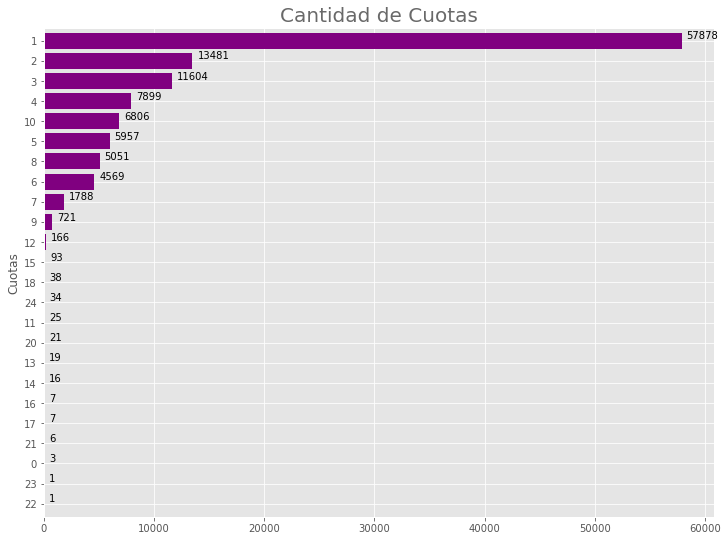

In [129]:
# payment installments
# Plot 2 - Payment installments
fig=plt.figure(figsize=(12,9))
ax = all_data['payment_installments'].value_counts(ascending=True).plot.barh(color='Purple', width=.8)
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

plt.title('Cantidad de Cuotas', color='dimgrey', size=20)
plt.ylabel('Cuotas')


In [130]:
all_data['payment_installments'].value_counts(normalize=True)

1     0.498128
2     0.116024
3     0.099870
4     0.067983
10    0.058576
5     0.051269
8     0.043472
6     0.039323
7     0.015388
9     0.006205
12    0.001429
15    0.000800
18    0.000327
24    0.000293
11    0.000215
20    0.000181
13    0.000164
14    0.000138
16    0.000060
17    0.000060
21    0.000052
0     0.000026
23    0.000009
22    0.000009
Name: payment_installments, dtype: float64

# Datos de los clientes

Creamos una tabla con algunos datos importantes para realizar la descripcion de los clientes, y consequentemente de los segmentos que serán creados.

#### Customer ID

In [236]:
# Crea un dataframe para almacenar customer_id y los valores de las segmentaciones
df = pd.DataFrame(all_data['customer_id'].unique())
df.columns = ['customer_id']
df.head()

customer_id
0  9ef432eb6251297304e76186b10a928d
1  a20e8105f23924cd00833fd87daa0831
2  26c7ac168e1433912a51b924fbd34d34
3  53904ddbea91e1e92b2b3f1d09a7af86
4  a7260a6ccba78544ccfaf43f920b7240

In [237]:
df

customer_id
0      9ef432eb6251297304e76186b10a928d
1      a20e8105f23924cd00833fd87daa0831
2      26c7ac168e1433912a51b924fbd34d34
3      53904ddbea91e1e92b2b3f1d09a7af86
4      a7260a6ccba78544ccfaf43f920b7240
...                                 ...
96939  e42e2e8642f9c09100b6667e321c2811
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc
96941  c4d135422be0d4333f506acde8af9419
96942  65d9213dfa004c17dc126503e106e4a3
96943  ff95df9a387c8d032a2ca6887cf77236

[96944 rows x 1 columns]

#### Recency

Para calcular recency, vamos utilizar la delivered order_purchase_timestamp

In [238]:
all_data['order_purchase_timestamp'].describe()

count                  116191
unique                  96409
top       2017-08-08 20:26:31
freq                       63
first     2017-01-05 11:56:06
last      2018-08-29 15:00:37
Name: order_purchase_timestamp, dtype: object

In [239]:
# Encontrar la última fecha de compra
client_r = all_data.groupby('customer_id').order_purchase_timestamp.max().reset_index()
client_r.columns = ['customer_id', 'max_purchase_date']
client_r.head()

customer_id   max_purchase_date
0  00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26
1  000161a058600d5901f007fab4c27140 2017-07-16 09:40:32
2  0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43
3  0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20
4  000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17

In [240]:
# Comparamos la última transacción del dataset con la última transcción de cada cliente
client_r['recency'] = (client_r['max_purchase_date'].max() - client_r['max_purchase_date']).dt.days
client_r.head()

customer_id   max_purchase_date  recency
0  00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26      287
1  000161a058600d5901f007fab4c27140 2017-07-16 09:40:32      409
2  0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43      547
3  0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20      378
4  000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17      149

In [241]:
# Unir el dataframe con el dataframe id_user
df = pd.merge(df, client_r[['customer_id','recency', 'max_purchase_date']], on='customer_id')
df.head()

customer_id  recency   max_purchase_date
0  9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33
1  a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31
2  26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47
3  53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46
4  a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28

In [242]:
df.recency.describe()

count    96944.000000
mean       238.017247
std        151.491017
min          0.000000
25%        115.000000
50%        219.000000
75%        348.000000
max        601.000000
Name: recency, dtype: float64

#### Frequency

Para encontrar los clusters de frecuencia, es necesario encontrar el numero total de pedidos para cada cliente. Primero encontramos ese valor y verificamos como se distribuye en el dataset.

In [243]:
# Obtener el numero de pedidos por cliente y crear un nuevo df
frequency_client = all_data.groupby('customer_id').order_item_id.count().reset_index()
frequency_client.columns = ['customer_id','frequency']
frequency_client.head()

customer_id  frequency
0  00012a2ce6f8dcda20d059ce98491703          1
1  000161a058600d5901f007fab4c27140          1
2  0001fd6190edaaf884bcaf3d49edf079          1
3  0002414f95344307404f0ace7a26f1d5          1
4  000379cdec625522490c315e70c7a9fb          1

In [244]:
# Merge del dato al dataset df_rfm
df = pd.merge(df, frequency_client, on='customer_id')
df.head()

customer_id  recency   max_purchase_date  frequency
0  9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33          3
1  a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31          1
2  26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47          1
3  53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46          1
4  a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28          2

In [245]:
df.frequency.describe()

count    96944.000000
mean         1.198537
std          0.751232
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         63.000000
Name: frequency, dtype: float64

In [246]:
(df.frequency.value_counts(normalize = True)).round(2)

1     0.87
2     0.10
3     0.02
4     0.01
6     0.00
5     0.00
7     0.00
8     0.00
12    0.00
10    0.00
9     0.00
11    0.00
15    0.00
24    0.00
14    0.00
13    0.00
20    0.00
21    0.00
16    0.00
22    0.00
38    0.00
19    0.00
26    0.00
29    0.00
63    0.00
Name: frequency, dtype: float64

#### Monetary Value

El monetary value es la suma de todos los pedidos realizados por cada cliente

In [247]:
monetary_value = all_data['payment_value'].groupby(all_data['customer_id']).sum().reset_index()
monetary_value.columns = ['customer_id','monetary_value']
monetary_value.head()

customer_id  monetary_value
0  00012a2ce6f8dcda20d059ce98491703          114.74
1  000161a058600d5901f007fab4c27140           67.41
2  0001fd6190edaaf884bcaf3d49edf079          195.42
3  0002414f95344307404f0ace7a26f1d5          179.35
4  000379cdec625522490c315e70c7a9fb          107.01

In [248]:
# Merge to df_rfm
df = pd.merge(df, monetary_value, on='customer_id')

In [249]:
df.monetary_value.mean()

207.13895166281074

#### Gasto medio por cliente

In [250]:
df['gasto_medio'] = (df['monetary_value'] / df['frequency']).round(2)
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio  
0              3           38.71        12.90  
1              1           37.77        37.77  
2              1           37.77        37.77  
3              1           44.09        44.09  
4              2          254.90       127.45  
...          ...             ...          ...  
96939          1           52.57        52.57  
96940          1           66.38        66.38  
96941          1           31.42        31.42  
96942          1          804.96       804.96  
96943          1          114.90       114.90  

[96944 rows x 6 columns]

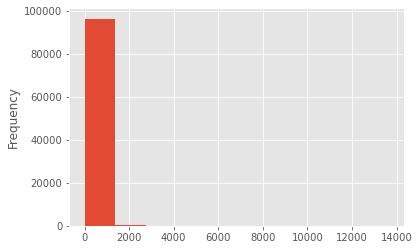

In [251]:
df['gasto_medio'].plot.hist()

In [252]:
df['gasto_medio'].mean()

158.04842280078108

#### Payment Type

In [253]:
all_data.payment_type.unique()                   

array(['credit_card', 'voucher', 'boleto', 'debit_card'], dtype=object)

In [254]:
# generate binary values using get_dummies
dum_df = pd.get_dummies(all_data, columns=["payment_type"])
dum_df = dum_df[['customer_id', 'payment_type_boleto','payment_type_credit_card','payment_type_debit_card','payment_type_voucher']]

payment = dum_df.groupby('customer_id')['payment_type_boleto','payment_type_credit_card','payment_type_debit_card','payment_type_voucher'].sum().reset_index()
payment.columns = ['customer_id','payment_type_boleto','payment_type_credit_card','payment_type_debit_card','payment_type_voucher']
payment

<ipython-input-254-4aaf81296425>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



customer_id  payment_type_boleto  \
0      00012a2ce6f8dcda20d059ce98491703                    0   
1      000161a058600d5901f007fab4c27140                    0   
2      0001fd6190edaaf884bcaf3d49edf079                    0   
3      0002414f95344307404f0ace7a26f1d5                    1   
4      000379cdec625522490c315e70c7a9fb                    1   
...                                 ...                  ...   
96939  fffcb937e9dd47a13f05ecb8290f4d3e                    0   
96940  fffecc9f79fd8c764f843e9951b11341                    0   
96941  fffeda5b6d849fbd39689bb92087f431                    0   
96942  ffff42319e9b2d713724ae527742af25                    0   
96943  ffffa3172527f765de70084a7e53aae8                    0   

       payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
0                             1                        0                     0  
1                             1                        0                     0  
2                             1                        0                     0  
3                             0                        0                     0  
4                             0                        0                     0  
...                         ...                      ...                   ...  
96939                         1                        0                     0  
96940                         1                        0                     2  
96941                         1                        0                     0  
96942                         1                        0                     0  
96943                         2                        0                     0  

[96944 rows x 5 columns]

In [255]:
def payment_type(df):
    if (df['payment_type_boleto']>0 and df['payment_type_credit_card']==0 and df['payment_type_debit_card']==0 and df['payment_type_voucher']==0):
        return 'boleto'
    if (df['payment_type_boleto']==0 and df['payment_type_credit_card']>0 and df['payment_type_debit_card']==0 and df['payment_type_voucher']==0):
        return 'credit'
    if (df['payment_type_boleto']==0 and df['payment_type_credit_card']==0 and df['payment_type_debit_card']>0 and df['payment_type_voucher']==0):
        return 'debit'
    if (df['payment_type_boleto']==0 and df['payment_type_credit_card']==0 and df['payment_type_debit_card']==0 and df['payment_type_voucher']>0):
        return 'voucher'

    return 'multiple'


In [256]:
payment['payment_type'] = payment.apply(payment_type, axis = 1)
payment

customer_id  payment_type_boleto  \
0      00012a2ce6f8dcda20d059ce98491703                    0   
1      000161a058600d5901f007fab4c27140                    0   
2      0001fd6190edaaf884bcaf3d49edf079                    0   
3      0002414f95344307404f0ace7a26f1d5                    1   
4      000379cdec625522490c315e70c7a9fb                    1   
...                                 ...                  ...   
96939  fffcb937e9dd47a13f05ecb8290f4d3e                    0   
96940  fffecc9f79fd8c764f843e9951b11341                    0   
96941  fffeda5b6d849fbd39689bb92087f431                    0   
96942  ffff42319e9b2d713724ae527742af25                    0   
96943  ffffa3172527f765de70084a7e53aae8                    0   

       payment_type_credit_card  payment_type_debit_card  \
0                             1                        0   
1                             1                        0   
2                             1                        0   
3                             0                        0   
4                             0                        0   
...                         ...                      ...   
96939                         1                        0   
96940                         1                        0   
96941                         1                        0   
96942                         1                        0   
96943                         2                        0   

       payment_type_voucher payment_type  
0                         0       credit  
1                         0       credit  
2                         0       credit  
3                         0       boleto  
4                         0       boleto  
...                     ...          ...  
96939                     0       credit  
96940                     2     multiple  
96941                     0       credit  
96942                     0       credit  
96943                     0       credit  

[96944 rows x 6 columns]

In [257]:
# Merge to df_rfm
df = pd.merge(df, payment[['customer_id','payment_type']], on='customer_id')
df 

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  
0              3           38.71        12.90     multiple  
1              1           37.77        37.77       credit  
2              1           37.77        37.77       credit  
3              1           44.09        44.09       boleto  
4              2          254.90       127.45       credit  
...          ...             ...          ...          ...  
96939          1           52.57        52.57       credit  
96940          1           66.38        66.38       credit  
96941          1           31.42        31.42       boleto  
96942          1          804.96       804.96       credit  
96943          1          114.90       114.90       credit  

[96944 rows x 7 columns]

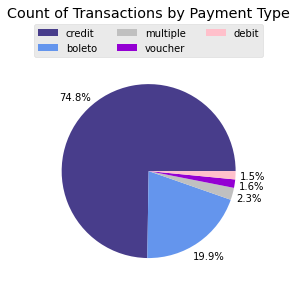

In [258]:
size_of_groups = df['payment_type'].value_counts()
labels = df['payment_type'].value_counts().index
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet','pink']
plt.pie(size_of_groups, colors=colors, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='lower center', bbox_to_anchor=(.5,1),ncol=3, fancybox=True)

plt.title('Count of Transactions by Payment Type', pad=45)
plt.show()


#### Score

In [259]:
all_data.review_score.unique()

array([4, 5, 3, 1, 2], dtype=int64)

In [260]:
score = all_data.groupby('customer_id')['review_score'].sum().reset_index()
score.columns = ['customer_id','review_score']
score

customer_id  review_score
0      00012a2ce6f8dcda20d059ce98491703             1
1      000161a058600d5901f007fab4c27140             4
2      0001fd6190edaaf884bcaf3d49edf079             5
3      0002414f95344307404f0ace7a26f1d5             5
4      000379cdec625522490c315e70c7a9fb             4
...                                 ...           ...
96939  fffcb937e9dd47a13f05ecb8290f4d3e             5
96940  fffecc9f79fd8c764f843e9951b11341             9
96941  fffeda5b6d849fbd39689bb92087f431             4
96942  ffff42319e9b2d713724ae527742af25             5
96943  ffffa3172527f765de70084a7e53aae8            10

[96944 rows x 2 columns]

In [261]:
# Merge to df_rfm
df = pd.merge(df, score[['customer_id','review_score']], on='customer_id')
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  
0              3           38.71        12.90     multiple            12  
1              1           37.77        37.77       credit             4  
2              1           37.77        37.77       credit             5  
3              1           44.09        44.09       boleto             3  
4              2          254.90       127.45       credit             2  
...          ...             ...          ...          ...           ...  
96939          1           52.57        52.57       credit             1  
96940          1           66.38        66.38       credit             5  
96941          1           31.42        31.42       boleto             5  
96942          1          804.96       804.96       credit             5  
96943          1          114.90       114.90       credit             1  

[96944 rows x 8 columns]

In [262]:
df['review_score_mean'] = (df['review_score']/df['frequency']).round(2)
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean  
0                    4.0  
1                    4.0  
2                    5.0  
3                    3.0  
4                    1.0  
...                  ...  
96939                1.0  
96940                5.0  
96941                5.0  
96942                5.0  
96943                1.0  

[96944 rows x 9 columns]

In [263]:
df['review_score_mean'].mean()

4.093550503383397

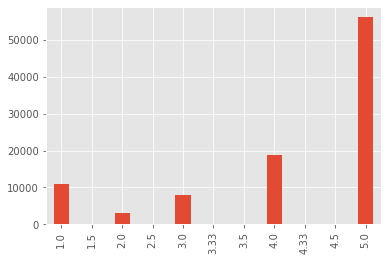

In [264]:
df['review_score_mean'].value_counts().sort_index().plot.bar()

#### Ciudad, Estado y Región

Selecionar la ciudad, estado y región del cliente con base en el último pedido

In [265]:
cer = all_data[['customer_id','customer_city', 'customer_state','customer_regiao', 'order_purchase_timestamp']]
cer.columns = ['customer_id','customer_city', 'customer_state','customer_regiao', 'date']
cer

customer_id   customer_city customer_state  \
0       9ef432eb6251297304e76186b10a928d       sao paulo             SP   
1       9ef432eb6251297304e76186b10a928d       sao paulo             SP   
2       9ef432eb6251297304e76186b10a928d       sao paulo             SP   
3       a20e8105f23924cd00833fd87daa0831       sao paulo             SP   
4       26c7ac168e1433912a51b924fbd34d34       sao paulo             SP   
...                                  ...             ...            ...   
116576  e42e2e8642f9c09100b6667e321c2811       sao paulo             SP   
116577  0cbd2df3d6e9d8b1eaf5cfefc44886bc  ribeirao pires             SP   
116578  c4d135422be0d4333f506acde8af9419       sao paulo             SP   
116579  65d9213dfa004c17dc126503e106e4a3         bacabal             MA   
116580  ff95df9a387c8d032a2ca6887cf77236    nova serrana             MG   

       customer_regiao                date  
0              Sudeste 2017-10-02 10:56:33  
1              Sudeste 2017-10-02 10:56:33  
2              Sudeste 2017-10-02 10:56:33  
3              Sudeste 2017-08-15 18:29:31  
4              Sudeste 2017-08-02 18:24:47  
...                ...                 ...  
116576         Sudeste 2018-07-11 22:27:32  
116577         Sudeste 2018-05-16 14:50:54  
116578         Sudeste 2018-06-13 12:19:26  
116579        Nordeste 2018-08-07 10:52:58  
116580         Sudeste 2017-02-19 22:31:47  

[116191 rows x 5 columns]

In [266]:
maxp = client_r[['customer_id','max_purchase_date']]
maxp.columns = ['customer_id','date']
maxp

customer_id                date
0      00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26
1      000161a058600d5901f007fab4c27140 2017-07-16 09:40:32
2      0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43
3      0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20
4      000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17
...                                 ...                 ...
96939  fffcb937e9dd47a13f05ecb8290f4d3e 2018-03-17 00:55:27
96940  fffecc9f79fd8c764f843e9951b11341 2018-03-29 16:59:26
96941  fffeda5b6d849fbd39689bb92087f431 2018-05-22 13:36:02
96942  ffff42319e9b2d713724ae527742af25 2018-06-13 16:57:05
96943  ffffa3172527f765de70084a7e53aae8 2017-09-02 11:53:32

[96944 rows x 2 columns]

In [267]:
cer_c = pd.merge(maxp, cer[['customer_id','customer_city', 'customer_state','customer_regiao', 'date']], on=['date', 'customer_id'])
cer_c = cer_c.drop_duplicates()
cer_c

customer_id                date    customer_city  \
0       00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26           osasco   
1       000161a058600d5901f007fab4c27140 2017-07-16 09:40:32      itapecerica   
2       0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43     nova venecia   
3       0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20         mendonca   
4       000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17        sao paulo   
...                                  ...                 ...              ...   
116183  fffcb937e9dd47a13f05ecb8290f4d3e 2018-03-17 00:55:27        sao paulo   
116184  fffecc9f79fd8c764f843e9951b11341 2018-03-29 16:59:26           parobe   
116187  fffeda5b6d849fbd39689bb92087f431 2018-05-22 13:36:02   rio de janeiro   
116188  ffff42319e9b2d713724ae527742af25 2018-06-13 16:57:05  taboao da serra   
116189  ffffa3172527f765de70084a7e53aae8 2017-09-02 11:53:32          alfenas   

       customer_state customer_regiao  
0                  SP         Sudeste  
1                  MG         Sudeste  
2                  ES         Sudeste  
3                  MG         Sudeste  
4                  SP         Sudeste  
...               ...             ...  
116183             SP         Sudeste  
116184             RS             Sul  
116187             RJ         Sudeste  
116188             SP         Sudeste  
116189             MG         Sudeste  

[96944 rows x 5 columns]

In [268]:
df = pd.merge(df, cer_c[['customer_id', 'customer_city', 'customer_state', 'customer_regiao']], on='customer_id')
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  
0                    4.0       sao paulo             SP         Sudeste  
1                    4.0       sao paulo             SP         Sudeste  
2                    5.0       sao paulo             SP         Sudeste  
3                    3.0   florianopolis             SC             Sul  
4                    1.0       sao paulo             SP         Sudeste  
...                  ...             ...            ...             ...  
96939                1.0       sao paulo             SP         Sudeste  
96940                5.0  ribeirao pires             SP         Sudeste  
96941                5.0       sao paulo             SP         Sudeste  
96942                5.0         bacabal             MA        Nordeste  
96943                1.0    nova serrana             MG         Sudeste  

[96944 rows x 12 columns]

In [269]:
df['customer_regiao'].value_counts(normalize=True)

Sudeste         0.686489
Sul             0.142123
Nordeste        0.094776
Centro-Oeste    0.058054
Norte           0.018557
Name: customer_regiao, dtype: float64

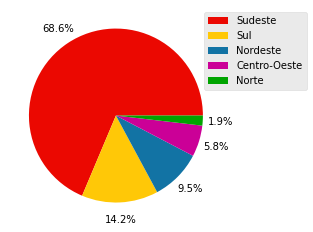

In [270]:
colores = ['#eb0801','#ffc807','#1273a4','#cb0097','#00a400']

size_of_groups = df['customer_regiao'].value_counts()
labels = df['customer_regiao'].value_counts().index
plt.pie(size_of_groups, colors=colores, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='upper right', bbox_to_anchor=(1.4,1))

plt.show()

#### Frete

In [271]:
frete = all_data.groupby('customer_id')['freight_value'].sum()
frete = frete.reset_index()
frete.columns=['customer_id','frete_total']
frete

customer_id  frete_total
0      00012a2ce6f8dcda20d059ce98491703        24.94
1      000161a058600d5901f007fab4c27140        12.51
2      0001fd6190edaaf884bcaf3d49edf079        15.43
3      0002414f95344307404f0ace7a26f1d5        29.45
4      000379cdec625522490c315e70c7a9fb        14.01
...                                 ...          ...
96939  fffcb937e9dd47a13f05ecb8290f4d3e        13.91
96940  fffecc9f79fd8c764f843e9951b11341        79.38
96941  fffeda5b6d849fbd39689bb92087f431        15.23
96942  ffff42319e9b2d713724ae527742af25        14.23
96943  ffffa3172527f765de70084a7e53aae8        23.70

[96944 rows x 2 columns]

In [272]:
df = pd.merge(df, frete[['customer_id','frete_total']], on='customer_id')
df['media_frete'] = df['frete_total']/df['frequency']
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  \
0                    4.0       sao paulo             SP         Sudeste   
1                    4.0       sao paulo             SP         Sudeste   
2                    5.0       sao paulo             SP         Sudeste   
3                    3.0   florianopolis             SC             Sul   
4                    1.0       sao paulo             SP         Sudeste   
...                  ...             ...            ...             ...   
96939                1.0       sao paulo             SP         Sudeste   
96940                5.0  ribeirao pires             SP         Sudeste   
96941                5.0       sao paulo             SP         Sudeste   
96942                5.0         bacabal             MA        Nordeste   
96943                1.0    nova serrana             MG         Sudeste   

       frete_total  media_frete  
0            26.16        8.720  
1             7.78        7.780  
2             7.78        7.780  
3            14.10       14.100  
4            70.75       35.375  
...            ...          ...  
96939         7.58        7.580  
96940         7.39        7.390  
96941         7.43        7.430  
96942        55.96       55.960  
96943        15.90       15.900  

[96944 rows x 14 columns]

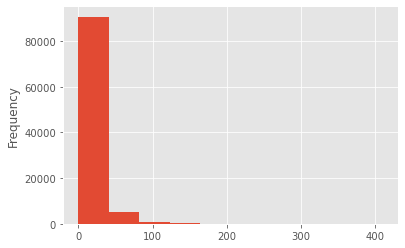

In [273]:
df['media_frete'].plot.hist()

In [274]:
df['media_frete'].mean()

20.226363769750012

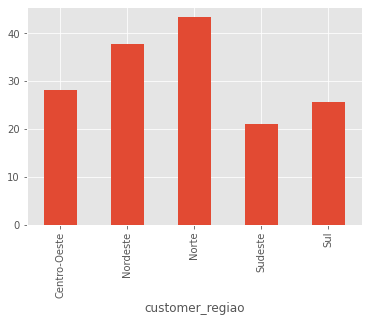

In [275]:
df.groupby('customer_regiao')['frete_total'].mean().plot.bar()

In [276]:
df.groupby('customer_regiao')['media_frete'].mean()

customer_regiao
Centro-Oeste    23.497017
Nordeste        32.243242
Norte           37.160062
Sudeste         17.583532
Sul             21.431259
Name: media_frete, dtype: float64

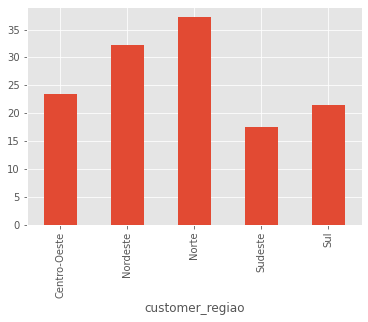

In [277]:
df.groupby('customer_regiao')['media_frete'].mean().plot.bar()

#### Periodo de compra

In [278]:
client_r

customer_id   max_purchase_date  recency
0      00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26      287
1      000161a058600d5901f007fab4c27140 2017-07-16 09:40:32      409
2      0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43      547
3      0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20      378
4      000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17      149
...                                 ...                 ...      ...
96939  fffcb937e9dd47a13f05ecb8290f4d3e 2018-03-17 00:55:27      165
96940  fffecc9f79fd8c764f843e9951b11341 2018-03-29 16:59:26      152
96941  fffeda5b6d849fbd39689bb92087f431 2018-05-22 13:36:02       99
96942  ffff42319e9b2d713724ae527742af25 2018-06-13 16:57:05       76
96943  ffffa3172527f765de70084a7e53aae8 2017-09-02 11:53:32      361

[96944 rows x 3 columns]

In [279]:
df_orders = client_r[['customer_id','max_purchase_date']]
df_orders['max_purchase_date'].astype(str)

0        2017-11-14 16:08:26
1        2017-07-16 09:40:32
2        2017-02-28 11:06:43
3        2017-08-16 13:09:20
4        2018-04-02 13:42:17
                ...         
96939    2018-03-17 00:55:27
96940    2018-03-29 16:59:26
96941    2018-05-22 13:36:02
96942    2018-06-13 16:57:05
96943    2017-09-02 11:53:32
Name: max_purchase_date, Length: 96944, dtype: object

In [280]:
df_orders['max_purchase_date'] = pd.to_datetime(df_orders['max_purchase_date'])
    
df_orders['order_purchase_hour'] = df_orders['max_purchase_date'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Madrugada','Mañana', 'Tarde', 'Noche']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

<ipython-input-280-6bdc6f70dc22>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



customer_id   max_purchase_date  order_purchase_hour  \
0  00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26                   16   
1  000161a058600d5901f007fab4c27140 2017-07-16 09:40:32                    9   
2  0001fd6190edaaf884bcaf3d49edf079 2017-02-28 11:06:43                   11   
3  0002414f95344307404f0ace7a26f1d5 2017-08-16 13:09:20                   13   
4  000379cdec625522490c315e70c7a9fb 2018-04-02 13:42:17                   13   

  order_purchase_time_day  
0                   Tarde  
1                  Mañana  
2                  Mañana  
3                   Tarde  
4                   Tarde

In [281]:
df = pd.merge(df, df_orders[['customer_id','order_purchase_time_day']], on='customer_id')
df

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  \
0                    4.0       sao paulo             SP         Sudeste   
1                    4.0       sao paulo             SP         Sudeste   
2                    5.0       sao paulo             SP         Sudeste   
3                    3.0   florianopolis             SC             Sul   
4                    1.0       sao paulo             SP         Sudeste   
...                  ...             ...            ...             ...   
96939                1.0       sao paulo             SP         Sudeste   
96940                5.0  ribeirao pires             SP         Sudeste   
96941                5.0       sao paulo             SP         Sudeste   
96942                5.0         bacabal             MA        Nordeste   
96943                1.0    nova serrana             MG         Sudeste   

       frete_total  media_frete order_purchase_time_day  
0            26.16        8.720                  Mañana  
1             7.78        7.780                   Tarde  
2             7.78        7.780                   Tarde  
3            14.10       14.100                   Noche  
4            70.75       35.375                  Mañana  
...            ...          ...                     ...  
96939         7.58        7.580                   Noche  
96940         7.39        7.390                   Tarde  
96941         7.43        7.430                  Mañana  
96942        55.96       55.960                  Mañana  
96943        15.90       15.900                   Noche  

[96944 rows x 15 columns]

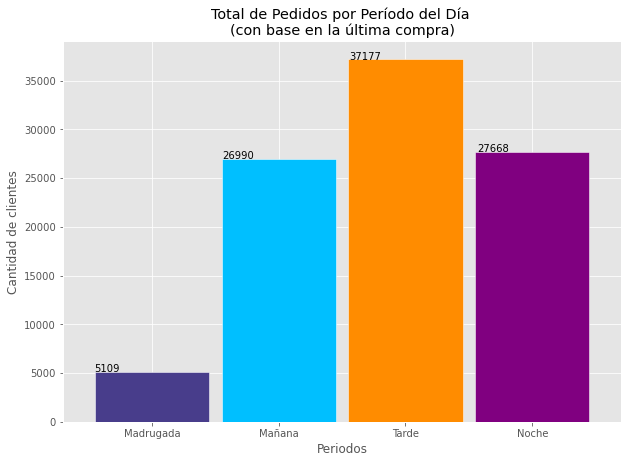

In [282]:
plt.figure(figsize=(10,7))
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']

ax = df['order_purchase_time_day'].value_counts().sort_index().plot(kind='bar',width=0.9,color=day_color_list, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
    
plt.xlabel('Periodos')
plt.ylabel('Cantidad de clientes')
plt.title('Total de Pedidos por Período del Día \n(con base en la última compra)')
plt.xticks(rotation='horizontal')

plt.show()

#### Review

In [344]:
comentario_positivo = olist_reviews.loc[olist_reviews['review_score']>=3].dropna().reset_index()
comentario_positivo

index                         review_id  \
0         9  8670d52e15e00043ae7de4c01cc2fe06   
1        15  3948b09f7c818e2d86c9a546758b2335   
2        22  d21bbc789670eab777d27372ab9094cc   
3        34  c92cdd7dd544a01aa35137f901669cdf   
4        36  08c9d79ec0eba1d252e3f52f14b8e6a9   
...     ...                               ...   
7634  99952  6740912e6b4bb99b3fad98dbc0f18afe   
7635  99962  47e0954e156dac6512c25c6d2ecc1c66   
7636  99967  0e7bc73fde6782891898ea71443f9904   
7637  99971  58be140ccdc12e8908ff7fd2ba5c7cb0   
7638  99972  51de4e06a6b701cb2be47ea0e689437b   

                              order_id  review_score  \
0     b9bf720beb4ab3728760088589c62129             4   
1     e51478e7e277a83743b6f9991dbfa3fb             5   
2     4fc44d78867142c627497b60a7e0228a             5   
3     37e7875cdce5a9e5b3a692971f370151             4   
4     e029f708df3cc108b3264558771605c6             5   
...                                ...           ...   
7634  a40874087359fab9b2c8a3aef56a97ad             5   
7635  16cbf959cfdb88c47ee2a29303547ec2             5   
7636  bd78f91afbb1ecbc6124974c5e813043             4   
7637  0ebf8e35b9807ee2d717922d5663ccdb             5   
7638  b7467ae483dbe956fe9acdf0b1e6e3f4             3   

           review_comment_title  \
0                     recomendo   
1               Super recomendo   
2                         Ótimo   
3                    Muito bom.   
4                           Bom   
...                         ...   
7634                  Confiável   
7635               Nota máxima!   
7636                          👍   
7637         muito bom produto    
7638  Não foi entregue o pedido   

                                 review_comment_message review_creation_date  \
0     aparelho eficiente. no site a marca do aparelh...  2018-05-22 00:00:00   
1     Vendedor confiável, produto ok e entrega antes...  2018-05-23 00:00:00   
2                                          Loja nota 10  2018-07-10 00:00:00   
3     Recebi exatamente o que esperava. As demais en...  2018-06-07 00:00:00   
4                                           Recomendo ,  2018-06-13 00:00:00   
...                                                 ...                  ...   
7634  Veio tudo certinho, lacradinho, dentro do praz...  2018-06-22 00:00:00   
7635  Muito obrigado,\r\n\r\nExcelente atendimento,b...  2018-05-22 00:00:00   
7636                                          Aprovado!  2018-07-04 00:00:00   
7637  Ficamos muito satisfeitos com o produto, atend...  2018-06-30 00:00:00   
7638  Bom dia \r\nDas 6 unidades compradas só recebi...  2018-06-05 00:00:00   

     review_answer_timestamp  
0        2018-05-23 16:45:47  
1        2018-05-24 03:00:01  
2        2018-07-11 14:10:25  
3        2018-06-09 18:44:02  
4        2018-06-13 22:54:44  
...                      ...  
7634     2018-06-23 17:28:41  
7635     2018-05-23 00:51:43  
7636     2018-07-05 00:25:13  
7637     2018-07-02 23:09:35  
7638     2018-06-06 10:52:19  

[7639 rows x 8 columns]

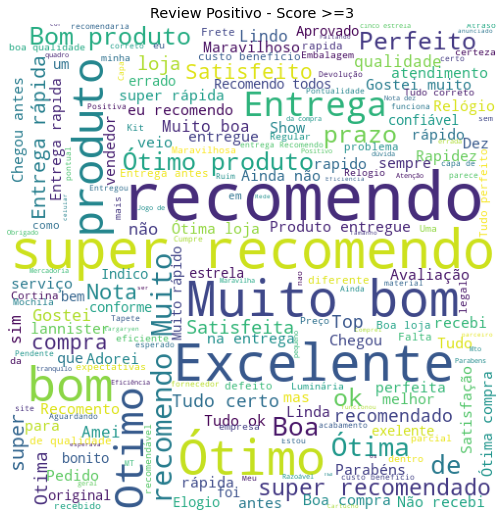

In [345]:
plt.figure(figsize=(15,9))

text = ' '.join(comentario_positivo['review_comment_title'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Review Positivo - Score >=3')
plt.show()

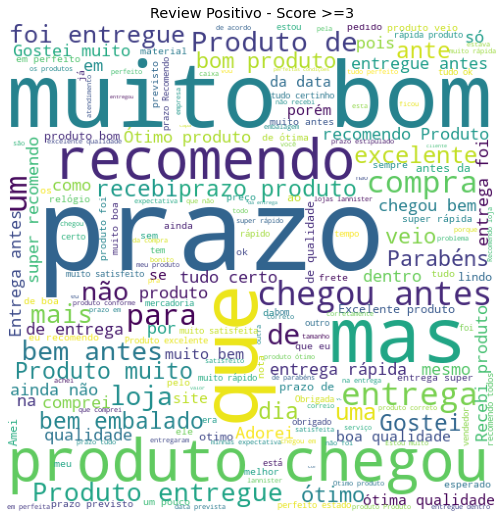

In [223]:
plt.figure(figsize=(15,9))

text = ' '.join(comentario_positivo['review_comment_message'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Review Positivo - Score >=3')
plt.show()

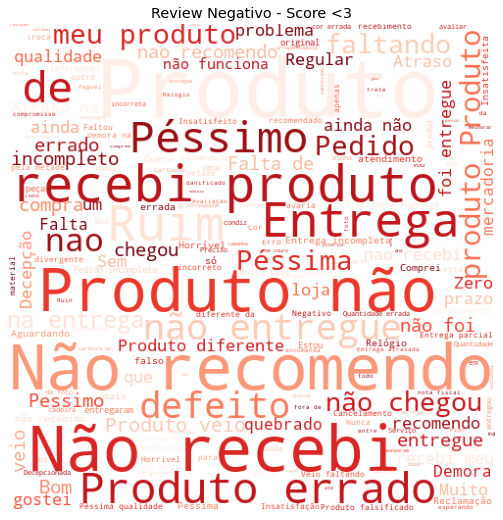

In [346]:
comentario_negativo = olist_reviews.loc[olist_reviews['review_score']<3].dropna().reset_index()

plt.figure(figsize=(15,9))

text = ' '.join(comentario_negativo['review_comment_title'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white', colormap="Reds").generate(text)
 
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Review Negativo - Score <3')
plt.show()

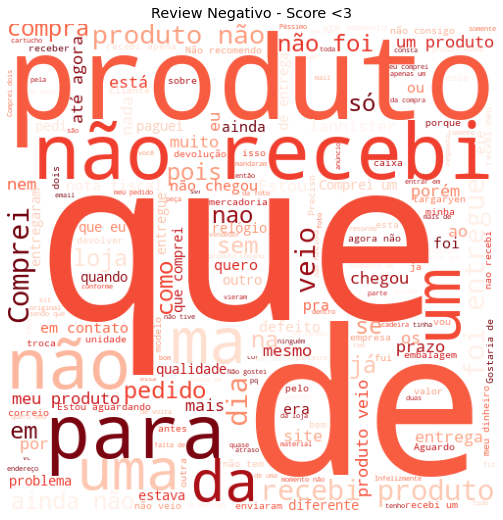

In [221]:
comentario_negativo = olist_reviews.loc[olist_reviews['review_score']<3].dropna().reset_index()

plt.figure(figsize=(15,9))

text = ' '.join(comentario_negativo['review_comment_message'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white', colormap="Reds").generate(text)
 
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Review Negativo - Score <3')
plt.show()

# ** 3. Modelado **

A partir de esta etapa, deben enfocarse en realizar una segmentación. Se recomienda utilizar el algoritmo de Kmeans para mayor facilidad, pero pueden probar varios. Además pueden investigar sobre qué es un análisis RFM (Recency, Frequency, and Monetary) para la segmentación de clientes, que puede ayudarlos a hacer un KMeans sobre ese análisis. A Modo de indicación, se los comento abajo, pero no es necesario que sigan con ese análisis, pueden realizar el que a uds les parezca.

## ** 3.1 Análisis RFM **

El análisis RFM es un método utilizado para ver patrones en los clientes en función de sus hábitos de compra:

1. Recency = ¿Cuándo fue la última vez que el cliente realizó una transacción?
 
2. Frecuencia = ¿Con qué frecuencia el cliente realiza una compra?

3. Monetario = cuánto gastan los clientes

Ahora analisamos las variables RFM individualmente para eliminar los outliers.

In [283]:
df_so = df.copy() 

#### Analisis de la distribución RFM

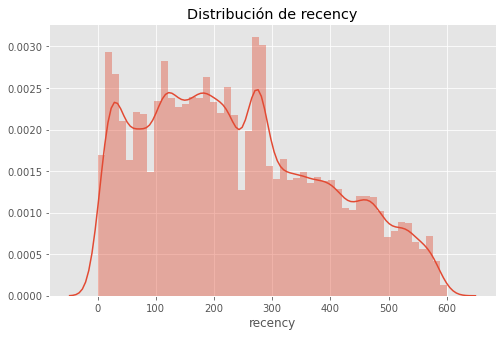

C:\Users\Cliente\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.



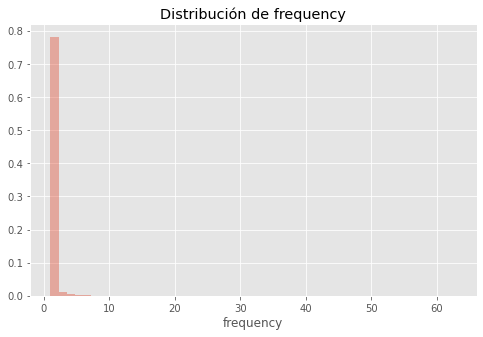

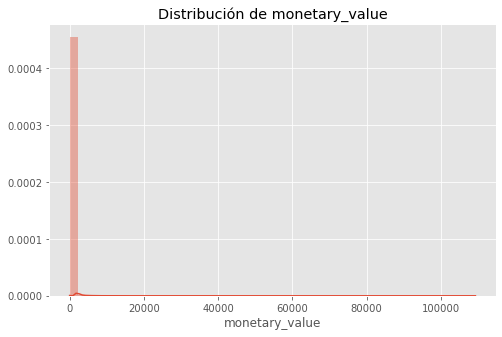

In [284]:
colnames = ['recency', 'frequency', 'monetary_value']

for col in colnames:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.distplot(df_so[col])
    ax.set_title('Distribución de %s' % col)
    plt.show()

<ul>
    <li> Los valores de <b>recency</b> están relativamente bien distribuídos, con algunos picos alrededor de 50 dias, 150 y 300. </li>
    <li> La distribución de la <b>frecuencia</b> muestra que la mayoria de los clientes tiene una frecuencia muy baja, la mayoria realizó apenas 1 compra </li>
    <li> El <b>valor monetario</b> también se concentra en una franja relativamente baja</li>
    </ul>

### TRATAMIENTO DE OUTLIERS

#### Monetary Value

In [285]:
df_so['monetary_value'].describe()

count     96944.000000
mean        207.138952
std         626.445194
min           9.590000
25%          63.000000
50%         110.000000
75%         197.020000
max      109312.640000
Name: monetary_value, dtype: float64

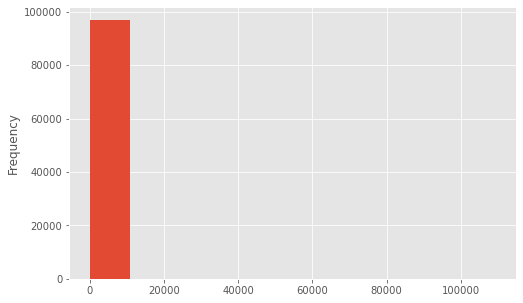

In [286]:
plt.figure(figsize=(8,5))
df_so['monetary_value'].plot.hist()

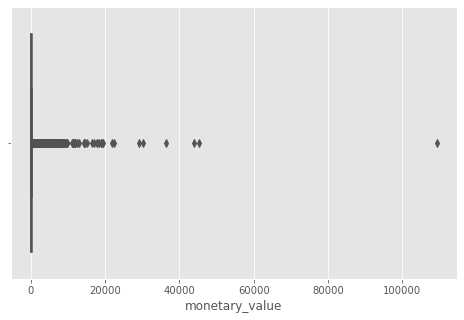

In [287]:
plt.figure(figsize=(8,5))
sns.boxplot(df_so['monetary_value'])

In [288]:
df_so.loc[df_so['monetary_value']<2000]

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  \
0                    4.0       sao paulo             SP         Sudeste   
1                    4.0       sao paulo             SP         Sudeste   
2                    5.0       sao paulo             SP         Sudeste   
3                    3.0   florianopolis             SC             Sul   
4                    1.0       sao paulo             SP         Sudeste   
...                  ...             ...            ...             ...   
96939                1.0       sao paulo             SP         Sudeste   
96940                5.0  ribeirao pires             SP         Sudeste   
96941                5.0       sao paulo             SP         Sudeste   
96942                5.0         bacabal             MA        Nordeste   
96943                1.0    nova serrana             MG         Sudeste   

       frete_total  media_frete order_purchase_time_day  
0            26.16        8.720                  Mañana  
1             7.78        7.780                   Tarde  
2             7.78        7.780                   Tarde  
3            14.10       14.100                   Noche  
4            70.75       35.375                  Mañana  
...            ...          ...                     ...  
96939         7.58        7.580                   Noche  
96940         7.39        7.390                   Tarde  
96941         7.43        7.430                  Mañana  
96942        55.96       55.960                  Mañana  
96943        15.90       15.900                   Noche  

[96257 rows x 15 columns]

In [289]:
m = (df_so.loc[df_so['monetary_value']<=100].count())[3]
v = m/(df_so['monetary_value'].count())
v.round(2)

0.46

In [290]:
m = (df_so.loc[(df_so['monetary_value']>100) & (df_so['monetary_value']<=500)].count())[3]
v = m/(df_so['monetary_value'].count())
v.round(2)

0.47

In [291]:
m = (df_so.loc[(df_so['monetary_value']>500) & (df_so['monetary_value']<=2000)].count())[3]
v = m/(df_so['monetary_value'].count())
v.round(2)

0.06

In [292]:
m = (df_so.loc[df_so['monetary_value']>2000].count())[3]
v = m/(df_so['monetary_value'].count())
v.round(2)

0.01

In [293]:
m = (df_so.loc[df_so['monetary_value']<2000].count())[3]
v = m/(df_so['monetary_value'].count())
v.round(2)

0.99

Los valores de monetary tienen una desviación muy alta. Podemos comprobar que la mayoria de los clientes, 99%, realizó compras con valores menores que R$2000. Probaremos eliminar los outliers utilizando el método Z-Score con Z<3.

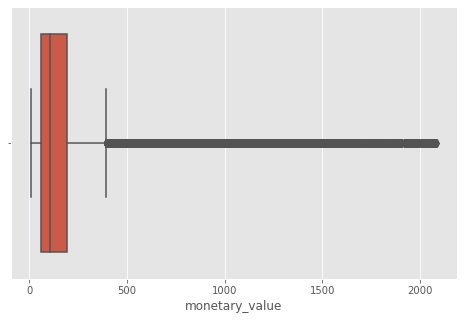

In [294]:
#remove outliers
z = np.abs(stats.zscore(df_so['monetary_value']))
df_so = df_so[(z < 3)]

plt.figure(figsize=(8,5))
sns.boxplot(df_so['monetary_value'])

In [295]:
df_so['monetary_value'].describe()

count    96325.000000
mean       179.640199
std        226.484624
min          9.590000
25%         62.780000
50%        109.160000
75%        194.760000
max       2085.360000
Name: monetary_value, dtype: float64

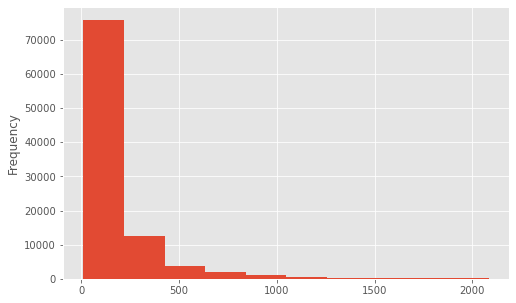

In [296]:
plt.figure(figsize=(8,5))
df_so['monetary_value'].plot.hist()

Los valores ahora están un poco mejor distribuídos.

#### Frequency

In [297]:
df_so.frequency.value_counts()

1     84143
2      9565
3      1446
4       705
6       184
5       170
7        30
8        23
12       12
9         9
11        8
10        6
24        5
15        4
14        3
13        2
16        2
38        1
19        1
20        1
21        1
22        1
26        1
29        1
63        1
Name: frequency, dtype: int64

La gran mayoria de los clientes realizaron una sola compra. Los clientes que compran más de 3 veces son muy pocos en comparación con el resto de los dados, así que eliminaremos las frecuencias mayores que 3.

In [298]:
# Eliminamos frequency > 3
df_so = df_so.drop(df_so[df_so['frequency']>3].index)

#### Recency

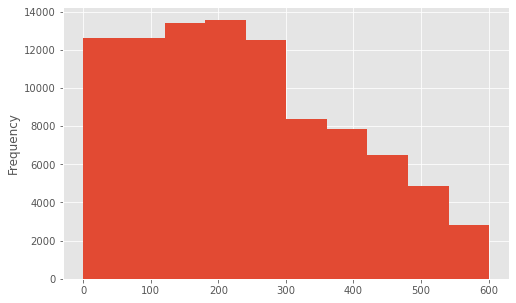

In [299]:
plt.figure(figsize=(8,5))
df_so['recency'].plot.hist()

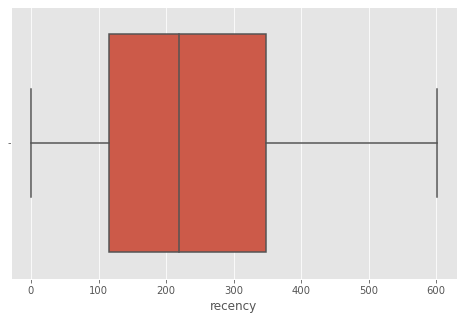

In [300]:
plt.figure(figsize=(8,5))
sns.boxplot(df_so['recency'])

In [301]:
df_so.describe()

recency     frequency  monetary_value   gasto_medio  review_score  \
count  95154.000000  95154.000000    95154.000000  95154.000000  95154.000000   
mean     237.805337      1.130914      172.741361    149.810163      4.592009   
std      151.398358      0.379697      209.886257    171.128542      2.098854   
min        0.000000      1.000000        9.590000      4.800000      1.000000   
25%      115.000000      1.000000       62.440000     60.050000      4.000000   
50%      219.000000      1.000000      107.935000    102.330000      5.000000   
75%      348.000000      1.000000      191.275000    172.620000      5.000000   
max      601.000000      3.000000     2085.360000   2082.360000     15.000000   

       review_score_mean   frete_total   media_frete  
count       95154.000000  95154.000000  95154.000000  
mean            4.104065     22.517185     20.093611  
std             1.330858     18.253359     15.252291  
min             1.000000      0.000000      0.000000  
25%             4.000000     13.950000     13.370000  
50%             5.000000     17.410000     16.390000  
75%             5.000000     24.890000     21.180000  
max             5.000000    409.680000    409.680000

### 3.1.1 Construcción de la Tabla RFM


### Tabla RFM

In [302]:
df_rfm = df_so[['recency','frequency','monetary_value']]

In [303]:
df_rfm.describe()

recency     frequency  monetary_value
count  95154.000000  95154.000000    95154.000000
mean     237.805337      1.130914      172.741361
std      151.398358      0.379697      209.886257
min        0.000000      1.000000        9.590000
25%      115.000000      1.000000       62.440000
50%      219.000000      1.000000      107.935000
75%      348.000000      1.000000      191.275000
max      601.000000      3.000000     2085.360000

### DEFINICIÓN DE SEGMENTOS

En esa sección se utilizarán diferentes enfoques para segmentar los clientes con base en los valores de RFM. 

### 1. K-Means Score R+F+M

En el primero enfoque utilizaremos el algoritmo KMeans para encontrar los clusters de cada uma das variables RFM. Después, con base en la clusterización individual, creamos un Score para segmentar los clientes. 

#### Clusterización Recency

Antes de ejecutar el algoritmo K-Means, utilizamos el Método Elbow para identificar el número de clusters ideal

In [347]:
rfm_C = df_so[['recency','frequency','monetary_value']]

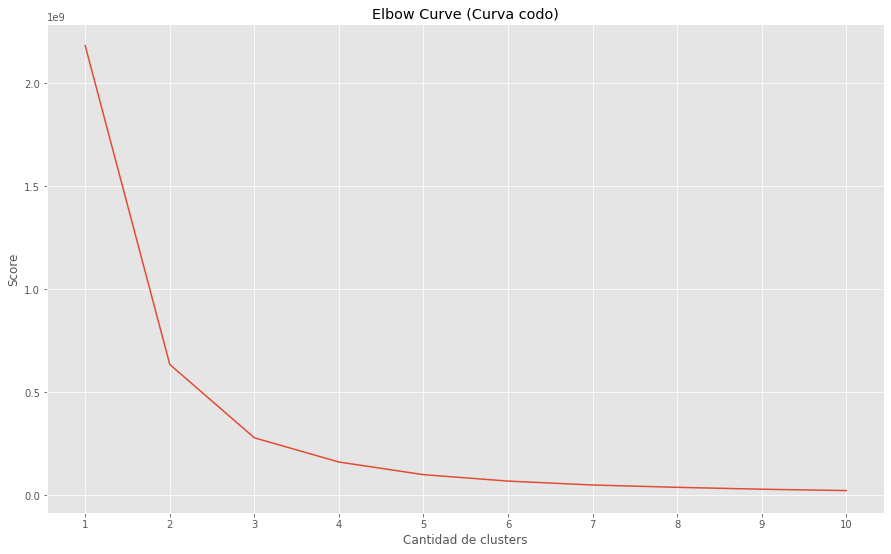

In [348]:
x = rfm_C[['recency']]

Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(x).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El gráfico nos muestra que el número ideal de clusters está entre 3 y 4. En este caso utilziaremos 4.

In [602]:
# Construir 4 clusters para recency y añadir al dataframe
kmeans = KMeans(n_clusters=4)
rfm_C['RecencyCluster'] = kmeans.fit_predict(rfm_C[['recency']])

In [603]:
rfm_C.groupby('RecencyCluster')['recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                               
0               26625.0  102.951174  36.032779    0.0   70.0  104.0  133.0   
1               17091.0  516.224914  53.291626  435.0  470.0  511.0  560.0   
2               28027.0  222.737218  35.917522  164.0  190.0  222.0  256.0   
3               23411.0  353.508351  43.074122  289.0  314.0  349.0  391.0   

                  max  
RecencyCluster         
0               163.0  
1               644.0  
2               288.0  
3               434.0

#### Ordenar los clusters

In [604]:
# Crea función para ordenar los clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [605]:
rfm_C=order_cluster('RecencyCluster','recency', rfm_C, False)
rfm_C.groupby('RecencyCluster')['recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                               
0               17091.0  516.224914  53.291626  435.0  470.0  511.0  560.0   
1               23411.0  353.508351  43.074122  289.0  314.0  349.0  391.0   
2               28027.0  222.737218  35.917522  164.0  190.0  222.0  256.0   
3               26625.0  102.951174  36.032779    0.0   70.0  104.0  133.0   

                  max  
RecencyCluster         
0               644.0  
1               434.0  
2               288.0  
3               163.0

Con los los clusters ordenados, verificamos que el cluster 0 es el más inactivo y cluster 3 el más activo.

#### Clusterización Frequency

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.

<ipython-input-606-b6133a21c183>:10: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.

<ipython-i

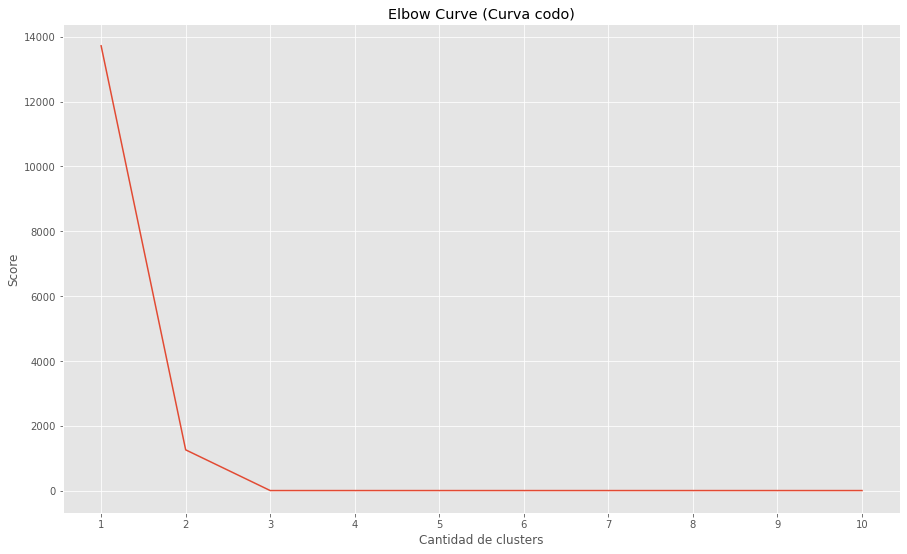

In [606]:
x = rfm_C[['frequency']]

Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(x).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El método elbow muestra que en este caso 3 es el número ideal de clusters. 

In [607]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_C[['frequency']])
rfm_C['FrequencyCluster'] = kmeans.predict(rfm_C[['frequency']])
rfm_C.head()

customer_id  recency  frequency  monetary_value  \
0  9ef432eb6251297304e76186b10a928d      371          3           38.71   
1  a20e8105f23924cd00833fd87daa0831      424          1           37.77   
2  53904ddbea91e1e92b2b3f1d09a7af86      343          1           44.09   
3  a7260a6ccba78544ccfaf43f920b7240      414          2          254.90   
4  50fd5707c28d0a64dc20d67f937dd9ba      362          1           50.05   

   RecencyCluster  FrequencyCluster  
0               1                 2  
1               1                 0  
2               1                 0  
3               1                 1  
4               1                 0

In [608]:
#ordena el cluster
rfm_C = order_cluster('FrequencyCluster', 'frequency', rfm_C, True)
rfm_C.groupby('FrequencyCluster')['frequency'].describe()

count  mean  std  min  25%  50%  75%  max
FrequencyCluster                                             
0                 84143.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
1                  9565.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
2                  1446.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0

Como selecionamos solo las frequencias 1, 2 y 3, era esperado que cada un de eses valores generaria un cluster. El cluster con más frecuencia es el cluster 2 y el con menos frecuencia es el cluster 0.

#### Clusterización de Monetary Value

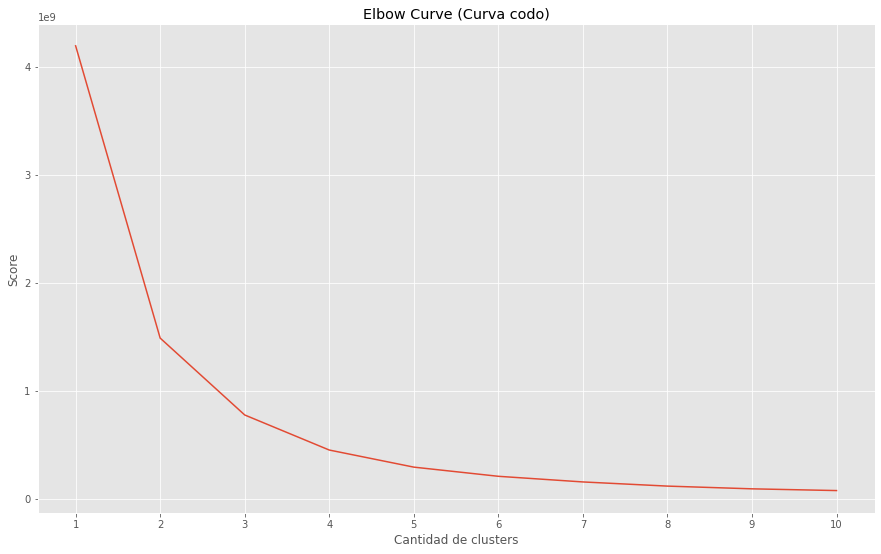

In [567]:
x = rfm_C[['monetary_value']]

Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(x).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El número ideal de clusters está entre 3 y 4. Utilziaremos 4 en este caso.

In [609]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_C[['monetary_value']])
rfm_C['MonetaryCluster'] = kmeans.predict(rfm_C[['monetary_value']])
rfm_C.head()

customer_id  recency  frequency  monetary_value  \
0  9ef432eb6251297304e76186b10a928d      371          3           38.71   
1  5aed239a8964c9d4307c5f47c0d81132      427          3          361.53   
2  29c938e10e5b108f3141464ff1bab857      308          3          332.10   
3  0ce02066b6e51b9fc335c98572058d4c      309          3          410.76   
4  34fa3fc9de4b0d9cb464ddd69dcb75ac      407          3          396.90   

   RecencyCluster  FrequencyCluster  MonetaryCluster  
0               1                 2                0  
1               1                 2                2  
2               1                 2                2  
3               1                 2                2  
4               1                 2                2

In [610]:
#ordena el cluster
rfm_C = order_cluster('MonetaryCluster', 'monetary_value', rfm_C, True)
rfm_C.groupby('MonetaryCluster')['monetary_value'].describe()

count         mean         std      min       25%  \
MonetaryCluster                                                        
0                69370.0    87.405441   42.480326     9.59    52.040   
1                19646.0   273.460795   77.427544   180.59   208.725   
2                 4933.0   672.869096  148.455819   473.68   546.650   
3                 1205.0  1395.885469  286.647657  1035.55  1157.040   

                      50%        75%      max  
MonetaryCluster                                
0                  80.090   118.8075   180.58  
1                 250.475   323.9175   473.62  
2                 641.180   778.0000  1035.03  
3                1323.790  1583.7100  2085.36

Cluster 3 es el cluster con mayor valor monetário y el cluster 0 con el menor.

#### RFM Clusters Overall Score

Ahora creamos un overall score somando los valores de los clusters.

In [611]:
#calcula el overall score 
rfm_C['OverallScore'] = rfm_C['RecencyCluster'] + rfm_C['FrequencyCluster'] + rfm_C['MonetaryCluster']
rfm_C.head()

customer_id  recency  frequency  monetary_value  \
0  9ef432eb6251297304e76186b10a928d      371          3           38.71   
1  250e5bd4f8a6b594bd1579ae588fe649      312          3           20.75   
2  f9f2cb313b6837f0a56e1d92fe67b0a6      344          3          113.91   
3  e5867bb6374f11c018bea8a8d1246c6d      350          3           89.42   
4  50a2bbfdc15bf77a19b7e096c8eadbcb      315          3           97.71   

   RecencyCluster  FrequencyCluster  MonetaryCluster  OverallScore  
0               1                 2                0             3  
1               1                 2                0             3  
2               1                 2                0             3  
3               1                 2                0             3  
4               1                 2                0             3

In [612]:
rfm_C.groupby('OverallScore')['recency','frequency','monetary_value'].mean()

<ipython-input-612-dac5c6188315>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  frequency  monetary_value
OverallScore                                       
0             516.104778   1.000000       84.913378
1             381.275981   1.037435      110.820356
2             261.283972   1.066712      129.773202
3             152.707642   1.100874      155.964402
4             161.971256   1.377458      349.342150
5             158.804807   1.798311      577.568948
6             147.645333   2.153778      857.885182
7             132.162791   2.740864     1046.475050
8             101.348485   3.000000     1428.271364

En el score 0 está los peore clientes y en el cluster 3 los mejores.

In [613]:
rfm_C['OverallScore'].value_counts()

3    26211
2    25168
1    19447
0    11825
4     7932
5     3079
6     1125
7      301
8       66
Name: OverallScore, dtype: int64

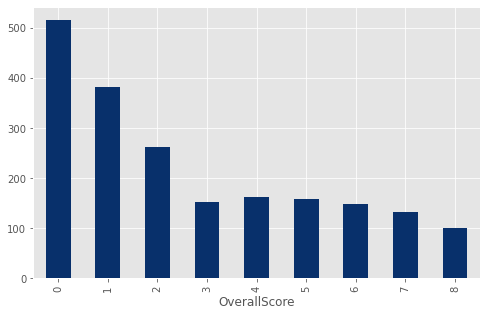

In [614]:
plt.figure(figsize=(8,5))
ax = rfm_C.groupby('OverallScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

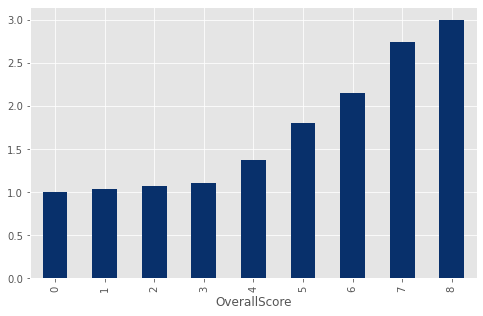

In [615]:
plt.figure(figsize=(8,5))
rfm_C.groupby('OverallScore').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

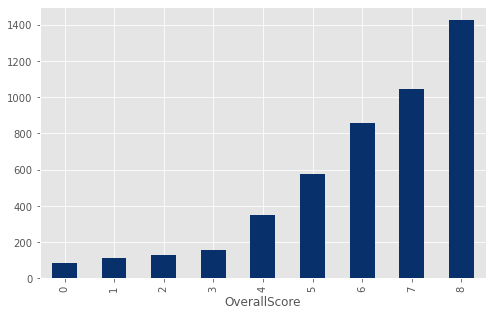

In [616]:
plt.figure(figsize=(8,5))
rfm_C.groupby('OverallScore').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

In [617]:
rfm_C['Segment_Value'] = np.nan
rfm_C.loc[rfm_C['OverallScore']>=0, 'Segment_Value'] = 'Low'
rfm_C.loc[rfm_C['OverallScore']>2, 'Segment_Value'] = 'Mid'
rfm_C.loc[rfm_C['OverallScore']>=6, 'Segment_Value'] = 'High'

rfm_C.head()

customer_id  recency  frequency  monetary_value  \
0  9ef432eb6251297304e76186b10a928d      371          3           38.71   
1  250e5bd4f8a6b594bd1579ae588fe649      312          3           20.75   
2  f9f2cb313b6837f0a56e1d92fe67b0a6      344          3          113.91   
3  e5867bb6374f11c018bea8a8d1246c6d      350          3           89.42   
4  50a2bbfdc15bf77a19b7e096c8eadbcb      315          3           97.71   

   RecencyCluster  FrequencyCluster  MonetaryCluster  OverallScore  \
0               1                 2                0             3   
1               1                 2                0             3   
2               1                 2                0             3   
3               1                 2                0             3   
4               1                 2                0             3   

  Segment_Value  
0           Mid  
1           Mid  
2           Mid  
3           Mid  
4           Mid

In [618]:
rfm_C['Segment_Value'].value_counts()

Low     56440
Mid     37222
High     1492
Name: Segment_Value, dtype: int64

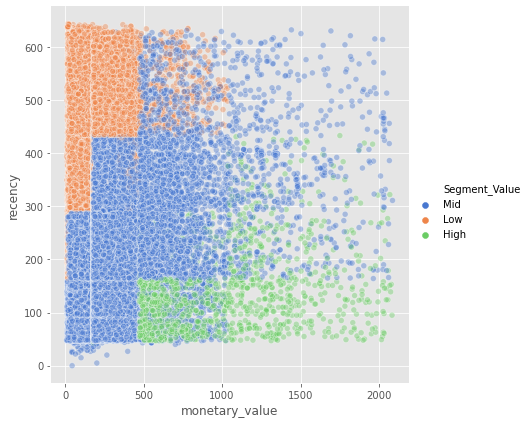

In [619]:
ax = sns.relplot(x="monetary_value",y="recency", hue="Segment_Value",
            sizes=(30, 300), alpha=.4, palette='muted',
            height=6, data=rfm_C)


Este enfoque no nos da clusters muy bien definidos. Pero se puede notar que los clientes Low concentranse en los menores valores monetarios y mayor valores de recency, mientras que los clientes High tienen un recency menor y un monetary mayor.

### 2. RFM Clusters K-Means

En este segundo enfoque aplicaremos el algoritmo K-Means simultaneamente para todas las variables RFM. Pero antes, realizaremos el tratamiento de los datos através del método IQR.

### Preprocessamiento para clusterización

In [620]:
df_rfm_out = df_rfm_so.copy() #al datatset ya con algunos outliers eliminados, aplicamos el método IQR

In [621]:
def outlier_treatment(df):
    numerical_columns = df.select_dtypes(include=['int32','int64', 'float64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3-Q1
        df.loc[ df[column] > (1.5*IQR), column ] = ( 1.5*IQR )
        df.loc[ df[column] < (-1.5*IQR), column] = ( -1.5*IQR )    

In [622]:
outlier_treatment(df_rfm_out)

In [623]:
df_rfm_out.describe()

recency  frequency  monetary_value
count  95154.000000    95154.0    95154.000000
mean     238.580249        0.0      115.933936
std      101.749809        0.0       59.215363
min        0.000000        0.0        9.590000
25%      153.000000        0.0       62.440000
50%      255.000000        0.0      107.935000
75%      348.000000        0.0      191.275000
max      348.000000        0.0      193.252500

#### Escalado de los datos

In [624]:
df_rfm_normal = df_rfm_out[['recency','frequency', 'monetary_value']]
df_rfm_normal.head()

recency  frequency  monetary_value
0    348.0        0.0         38.7100
1    348.0        0.0         37.7700
2    348.0        0.0         37.7700
3    343.0        0.0         44.0900
4    348.0        0.0        193.2525

In [625]:
scaler = StandardScaler()
scaler.fit(df_rfm_normal)
df_rfm_normal = scaler.transform(df_rfm_normal)

df_rfm_normal = pd.DataFrame(df_rfm_normal, index=df_rfm_out.index)
df_rfm_normal.columns=['recency', 'frequency', 'monetary_value']

# Check result after standardising
df_rfm_normal.describe()

recency  frequency  monetary_value
count  9.515400e+04    95154.0    9.515400e+04
mean  -8.972605e-16        0.0    6.925807e-15
std    1.000005e+00        0.0    1.000005e+00
min   -2.344786e+00        0.0   -1.795894e+00
25%   -8.410895e-01        0.0   -9.033841e-01
50%    1.613746e-01        0.0   -1.350828e-01
75%    1.075386e+00        0.0    1.272330e+00
max    1.075386e+00        0.0    1.305725e+00

#### Numero ideal de clusters

In [626]:
X=df_rfm_normal.copy()

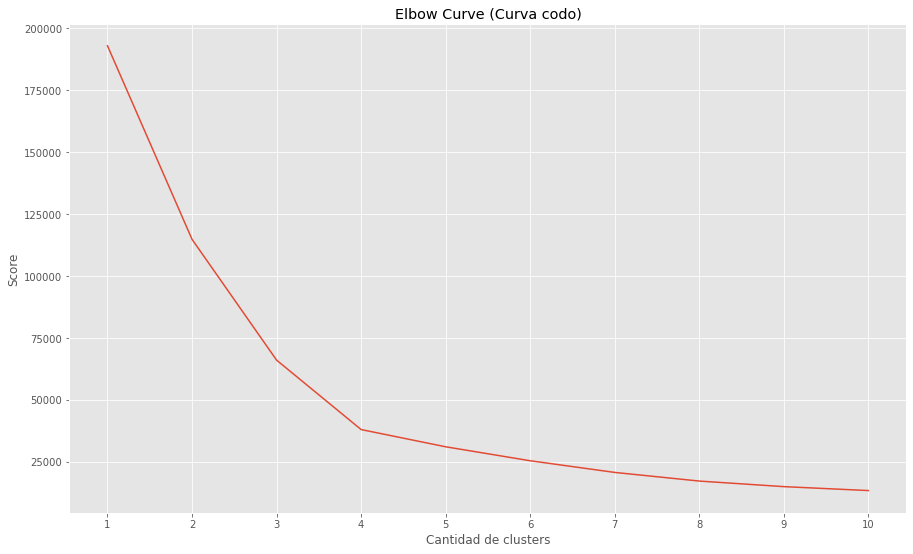

In [249]:
Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(X).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El gráfico nos muestra que el número ideal de clusters es 4.

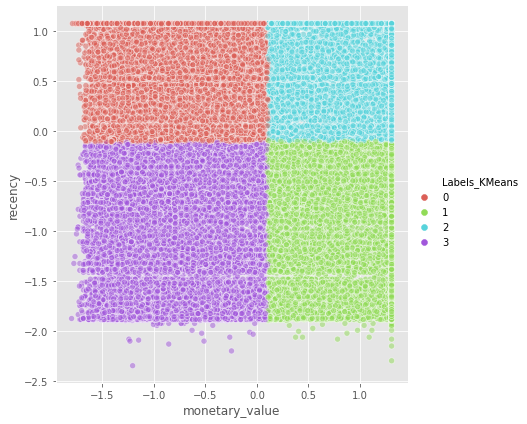

In [627]:
#4 clusters
km4 = KMeans(n_clusters=4).fit(X)

X['Labels_KMeans'] = km4.labels_
sns.relplot(x="monetary_value", y="recency", hue=X['Labels_KMeans'],
            sizes=(50, 500), alpha=.5,palette=sns.color_palette('hls', 4),
            height=6, data=X)

Los clusters ahora estan mucho mejor segmentados. Agregamos los labels a la tabla RFM con los datos originales:

In [628]:
clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rfm_cluster = df_rfm_so.copy()
rfm_cluster = pd.concat([rfm_cluster, clusters], axis=1, sort = False)
rfm_cluster

customer_id  recency  frequency  monetary_value  \
0      9ef432eb6251297304e76186b10a928d      371          3           38.71   
1      a20e8105f23924cd00833fd87daa0831      424          1           37.77   
2      26c7ac168e1433912a51b924fbd34d34      435          1           37.77   
3      53904ddbea91e1e92b2b3f1d09a7af86      343          1           44.09   
4      a7260a6ccba78544ccfaf43f920b7240      414          2          254.90   
...                                 ...      ...        ...             ...   
96939  e42e2e8642f9c09100b6667e321c2811       88          1           52.57   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      148          1           66.38   
96941  c4d135422be0d4333f506acde8af9419      122          1           31.42   
96942  65d9213dfa004c17dc126503e106e4a3       55          1          804.96   
96943  ff95df9a387c8d032a2ca6887cf77236      595          1          114.90   

       cluster  
0            0  
1            0  
2            0  
3            0  
4            2  
...        ...  
96939        3  
96940        3  
96941        3  
96942        1  
96943        0  

[95154 rows x 5 columns]

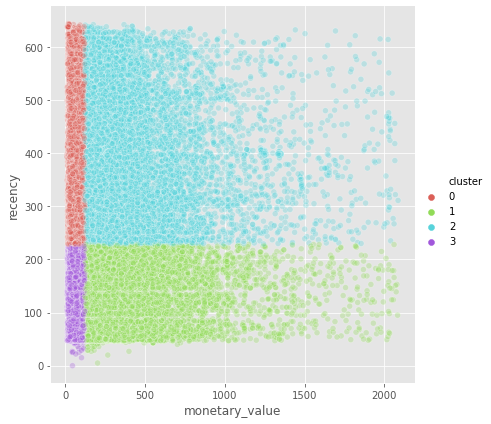

In [629]:
sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 4),
            height=6, data=rfm_cluster)

In [630]:
rfm_cluster.groupby('cluster')['recency','frequency','monetary_value'].mean()

<ipython-input-630-8a89d397f7e2>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  frequency  monetary_value
cluster                                       
0        382.192237   1.046383       68.485618
1        136.803291   1.233795      303.378453
2        383.725903   1.249727      305.206205
3        136.077620   1.037606       68.622927

Los clusters ahora están mucho mejor segmentados. EL algoritmo nos da 4 clusters, pero vemos que los clusters 0 y 2 tienen la misma média de monetary value, lo mismo para los clusters 1 y 3. Lo que diferencia los "pares" de clusters es principalmente el recency. Los valores de frequency no cambian mucho, una vez que la mayoria de los clientes hizo solo una compra.
Probando con más clusters para ver se nos dá clusters un poco más variados.

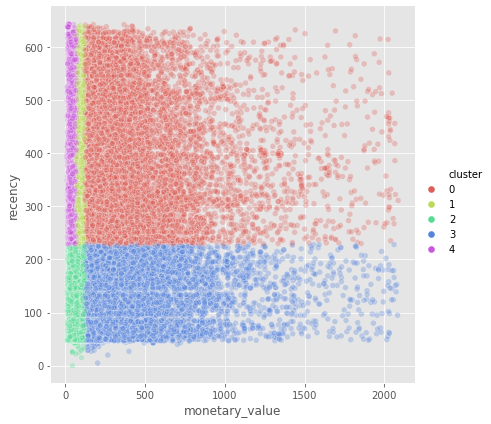

In [631]:
#5 clusters
km5 = KMeans(n_clusters=5).fit(X)

X['Labels_KMeans'] = km5.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rfm_cluster5 = df_rfm_so.copy()
rfm_cluster5 = pd.concat([rfm_cluster5, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster', 
            sizes=(30, 300), alpha=.3,palette=sns.color_palette('hls', 5),
            height=6, data=rfm_cluster5)

In [632]:
rfm_cluster5.groupby('cluster')['recency','frequency','monetary_value'].mean()

<ipython-input-632-8f0f8aa553fa>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  frequency  monetary_value
cluster                                       
0        383.725903   1.249727      305.206205
1        383.365008   1.057412       94.359919
2        136.077620   1.037606       68.622927
3        136.803291   1.233795      303.378453
4        381.237233   1.037401       47.415835

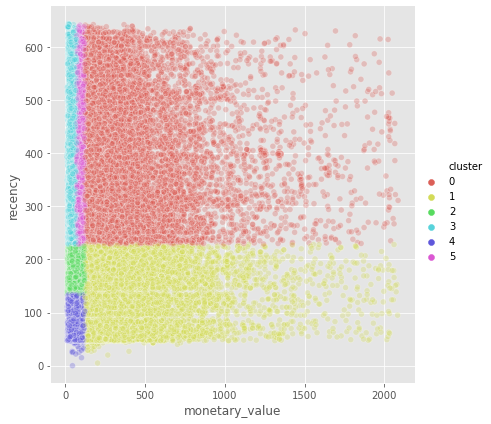

In [633]:
#6 clusters
km6 = KMeans(n_clusters=6).fit(X)
X['Labels_KMeans'] = km6.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rfm_cluster6 = df_rfm_so.copy()
rfm_cluster6 = pd.concat([rfm_cluster6, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 6),
            height=6, data=rfm_cluster6)

In [634]:
rfm_cluster6.groupby('cluster')['recency','frequency','monetary_value'].mean()

<ipython-input-634-bd85434c612b>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  frequency  monetary_value
cluster                                       
0        383.725903   1.249727      305.206205
1        136.803291   1.233795      303.378453
2        182.221394   1.036256       68.301161
3        381.237233   1.037401       47.415835
4         87.902282   1.039016       68.958859
5        383.365008   1.057412       94.359919

Aumentando el numero de clusters, vemos que el algoritmo da nuevos clusters para los clientes que tienen un menor valor monetario y mayor recency.

### 3. Recency y Monetary Clusters K-Means

Una vez que los valores de frequency no tienen mucha variabilidad, probaremos hacer la clusterización solo con los valores de recency y monetary value, para ver si cambian un poco los grupos. Utilizaremos la variable Frequency para ayudar en la descripción de los grupos.

In [304]:
df_rm = df[['recency', 'monetary_value']]
df_rm.head()

recency  monetary_value
0      331           38.71
1      378           37.77
2      391           37.77
3      309           44.09
4      370          254.90

Para el tratamiento de outliers, eliminaremos solo los valores de monetary value mayores que 10000. Antes habiamos utilizado el Z-Score, y nos quedamos solo con valores monetary menores que 2000, pero puede ser que los otros valores sean utilziados para formar un nuevo cluster. Vamos ver.

In [305]:
#Tratamiento de outliers
df_rm_so = df_rm.copy()
df_rm_so = df_rm_so.drop(df_rm_so[df_rm_so['monetary_value']>10000].index)


In [306]:
## Probando solo con recency y monetary value
df_rm_normal = df_rm_so.copy()

scaler = StandardScaler()
scaler.fit(df_rm_normal)
df_rm_normal = scaler.transform(df_rm_normal)

df_rm_normal = pd.DataFrame(df_rm_normal, index=df_rm_so.index)
df_rm_normal.columns=['recency', 'monetary_value']

# Check result after standardising
df_rm_normal.describe()

recency  monetary_value
count  9.691200e+04    9.691200e+04
mean   8.879310e-17   -4.022522e-16
std    1.000005e+00    1.000005e+00
min   -1.571146e+00   -5.166608e-01
25%   -8.120334e-01   -3.718701e-01
50%   -1.255319e-01   -2.444436e-01
75%    7.259940e-01   -8.798524e-03
max    2.396041e+00    2.591658e+01

In [307]:
X=df_rm_normal.copy()

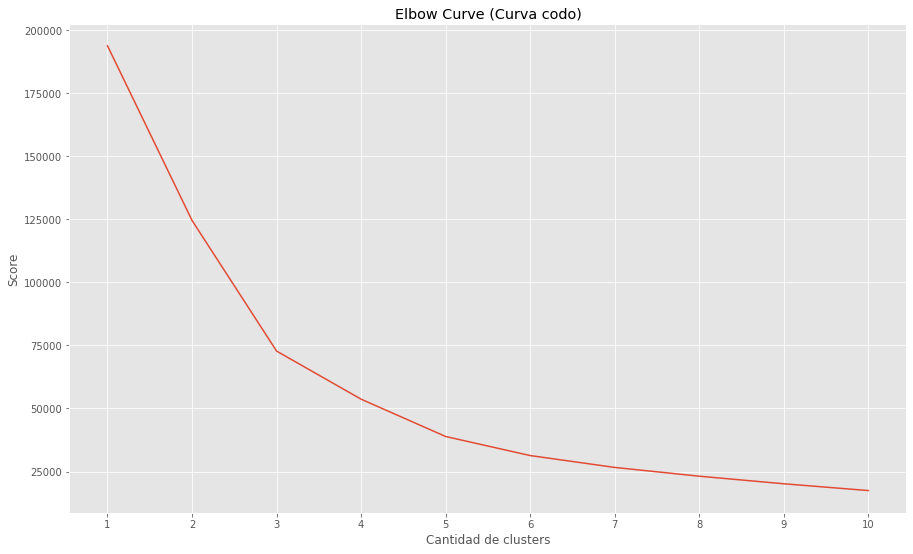

In [100]:
Nc = range(1, 11)
kmeans = [None] * 10
for i in Nc:
    kmeans[i-1] = KMeans(n_clusters=i)

score = [None] * 10
for i in range(len(kmeans)):
    score[i] = (kmeans[i].fit(X).inertia_) 

plt.figure(figsize=(15,9))
plt.plot(Nc,score)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve (Curva codo)')
plt.xticks(Nc)
plt.show()

El número ideal de cluster es 4.

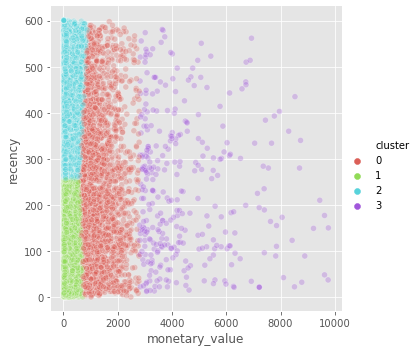

In [126]:
#4 clusters
km4 = KMeans(n_clusters=4).fit(X)
X['Labels_KMeans'] = km4.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rm_cluster4 = df_rm_so.copy()
rm_cluster4 = pd.concat([rm_cluster4, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 4),
            height=5, data=rm_cluster4)

In [127]:
rm_cluster4.groupby('cluster')['recency','monetary_value'].mean()

<ipython-input-127-78c31f34ff6c>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  monetary_value
cluster                            
0        229.694540     1141.082730
1        127.077288      142.562911
2        385.802593      144.544023
3        237.102102     4477.526036

In [128]:
rm_cluster4['cluster'].value_counts()

1    52712
2    39801
0     4066
3      333
Name: cluster, dtype: int64

Probando con otros valores de K:

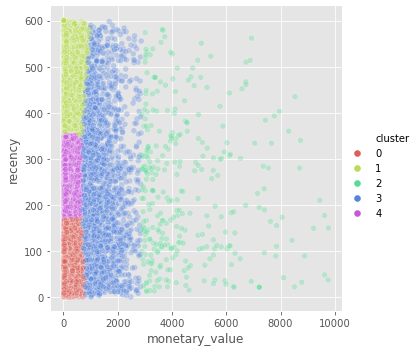

In [308]:
#5 clusters
km5 = KMeans(n_clusters=5).fit(X)
X['Labels_KMeans'] = km5.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rm_cluster5 = df_rm_so.copy()
rm_cluster5 = pd.concat([rm_cluster5, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.3,palette=sns.color_palette('hls', 5),
            height=5, data=rm_cluster5)


In [309]:
rm_cluster5.groupby('cluster')['recency','monetary_value'].mean()

<ipython-input-309-e651e520c087>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  monetary_value
cluster                            
0         86.065211      147.452664
1        453.916482      149.482314
2        235.081505     4549.466426
3        228.301162     1204.515232
4        253.382453      142.791358

In [310]:
rm_cluster5['cluster'].value_counts()

0    35316
4    35139
1    22522
3     3616
2      319
Name: cluster, dtype: int64

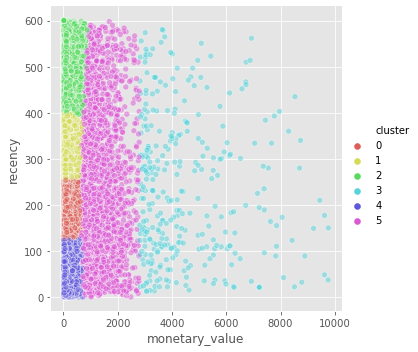

In [132]:
#6 clusters
km6 = KMeans(n_clusters=6).fit(X)
X['Labels_KMeans'] = km6.labels_

clusters = X[['Labels_KMeans']]
clusters.columns = ['cluster']

rm_cluster6 = df_rm_so.copy()
rm_cluster6 = pd.concat([rm_cluster6, clusters], axis=1, sort = False)

sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.5,palette=sns.color_palette('hls', 6),
            height=5, data=rm_cluster6)

In [133]:
rm_cluster6.groupby('cluster')['recency','monetary_value'].mean()

<ipython-input-133-a8f0c5301351>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



recency  monetary_value
cluster                            
0        187.408610      138.638403
1        317.554826      141.522696
2        480.576348      148.871415
3        237.102102     4477.526036
4         63.090380      146.725214
5        229.444991     1141.272095

In [134]:
rm_cluster6['cluster'].value_counts()

0    27131
4    25581
1    23137
2    16667
5     4063
3      333
Name: cluster, dtype: int64

Consideramos que la clusterización utilizando solo los valores de Recency y Monetary value nos dan clusters mejores. Así que utilizaremos la clusterización RM con 5 grupos para segmentar nuestros clientes.

## Descripción de Clusters

In [311]:
df_cluster = df.copy()

In [312]:
df_cluster = df_cluster.drop(df_cluster[df_cluster['monetary_value']>10000].index)
df_cluster

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  \
0                    4.0       sao paulo             SP         Sudeste   
1                    4.0       sao paulo             SP         Sudeste   
2                    5.0       sao paulo             SP         Sudeste   
3                    3.0   florianopolis             SC             Sul   
4                    1.0       sao paulo             SP         Sudeste   
...                  ...             ...            ...             ...   
96939                1.0       sao paulo             SP         Sudeste   
96940                5.0  ribeirao pires             SP         Sudeste   
96941                5.0       sao paulo             SP         Sudeste   
96942                5.0         bacabal             MA        Nordeste   
96943                1.0    nova serrana             MG         Sudeste   

       frete_total  media_frete order_purchase_time_day  
0            26.16        8.720                  Mañana  
1             7.78        7.780                   Tarde  
2             7.78        7.780                   Tarde  
3            14.10       14.100                   Noche  
4            70.75       35.375                  Mañana  
...            ...          ...                     ...  
96939         7.58        7.580                   Noche  
96940         7.39        7.390                   Tarde  
96941         7.43        7.430                  Mañana  
96942        55.96       55.960                  Mañana  
96943        15.90       15.900                   Noche  

[96912 rows x 15 columns]

In [313]:
cluster_label = rm_cluster5['cluster']

In [314]:
df_cluster = pd.concat([df_cluster, cluster_label], axis=1, sort = False)
df_cluster

customer_id  recency   max_purchase_date  \
0      9ef432eb6251297304e76186b10a928d      331 2017-10-02 10:56:33   
1      a20e8105f23924cd00833fd87daa0831      378 2017-08-15 18:29:31   
2      26c7ac168e1433912a51b924fbd34d34      391 2017-08-02 18:24:47   
3      53904ddbea91e1e92b2b3f1d09a7af86      309 2017-10-23 23:26:46   
4      a7260a6ccba78544ccfaf43f920b7240      370 2017-08-24 11:31:28   
...                                 ...      ...                 ...   
96939  e42e2e8642f9c09100b6667e321c2811       48 2018-07-11 22:27:32   
96940  0cbd2df3d6e9d8b1eaf5cfefc44886bc      105 2018-05-16 14:50:54   
96941  c4d135422be0d4333f506acde8af9419       77 2018-06-13 12:19:26   
96942  65d9213dfa004c17dc126503e106e4a3       22 2018-08-07 10:52:58   
96943  ff95df9a387c8d032a2ca6887cf77236      555 2017-02-19 22:31:47   

       frequency  monetary_value  gasto_medio payment_type  review_score  \
0              3           38.71        12.90     multiple            12   
1              1           37.77        37.77       credit             4   
2              1           37.77        37.77       credit             5   
3              1           44.09        44.09       boleto             3   
4              2          254.90       127.45       credit             2   
...          ...             ...          ...          ...           ...   
96939          1           52.57        52.57       credit             1   
96940          1           66.38        66.38       credit             5   
96941          1           31.42        31.42       boleto             5   
96942          1          804.96       804.96       credit             5   
96943          1          114.90       114.90       credit             1   

       review_score_mean   customer_city customer_state customer_regiao  \
0                    4.0       sao paulo             SP         Sudeste   
1                    4.0       sao paulo             SP         Sudeste   
2                    5.0       sao paulo             SP         Sudeste   
3                    3.0   florianopolis             SC             Sul   
4                    1.0       sao paulo             SP         Sudeste   
...                  ...             ...            ...             ...   
96939                1.0       sao paulo             SP         Sudeste   
96940                5.0  ribeirao pires             SP         Sudeste   
96941                5.0       sao paulo             SP         Sudeste   
96942                5.0         bacabal             MA        Nordeste   
96943                1.0    nova serrana             MG         Sudeste   

       frete_total  media_frete order_purchase_time_day  cluster  
0            26.16        8.720                  Mañana        4  
1             7.78        7.780                   Tarde        1  
2             7.78        7.780                   Tarde        1  
3            14.10       14.100                   Noche        4  
4            70.75       35.375                  Mañana        1  
...            ...          ...                     ...      ...  
96939         7.58        7.580                   Noche        0  
96940         7.39        7.390                   Tarde        0  
96941         7.43        7.430                  Mañana        0  
96942        55.96       55.960                  Mañana        3  
96943        15.90       15.900                   Noche        1  

[96912 rows x 16 columns]

<Figure size 1080x648 with 0 Axes>

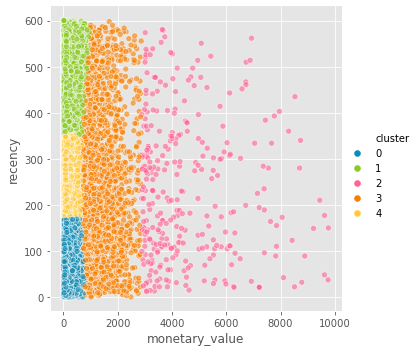

In [329]:
plt.figure(figsize = (15,9))
colors = ['#118ab2', '#8ac926','#ff6392','#f77f00','#ffca3a']

ax = sns.relplot(x="monetary_value", y="recency", hue='cluster',
            sizes=(50, 500), alpha=.6,palette=colors,
            height=5, data=df_cluster)
plt.show()

In [391]:
df_cluster['cluster'].value_counts(normalize=True)*100

0    36.441308
4    36.258668
1    23.239640
3     3.731220
2     0.329165
Name: cluster, dtype: float64

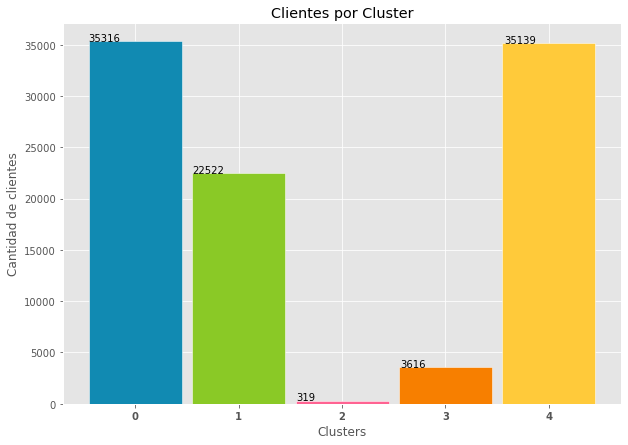

In [330]:
colors = ['#118ab2', '#8ac926','#ff6392','#f77f00','#ffca3a']

plt.figure(figsize=(10,7))
ax = df_cluster['cluster'].value_counts().sort_index().plot(kind='bar',width=0.9,color=colors, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
    
plt.xlabel('Clusters')
plt.ylabel('Cantidad de clientes')
plt.title('Clientes por Cluster')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

#### RFM

In [321]:
df_rfm = df_cluster[['recency','frequency','monetary_value','cluster']]

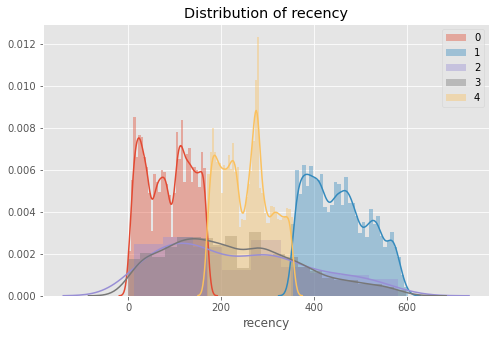

C:\Users\Cliente\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\Cliente\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

C:\Users\Cliente\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.



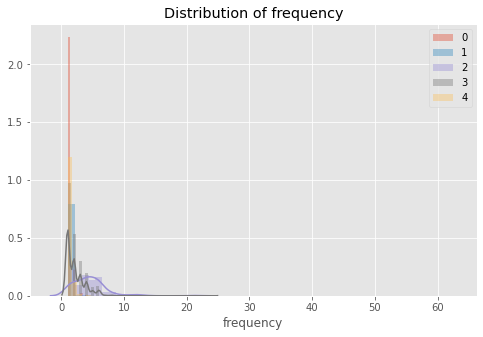

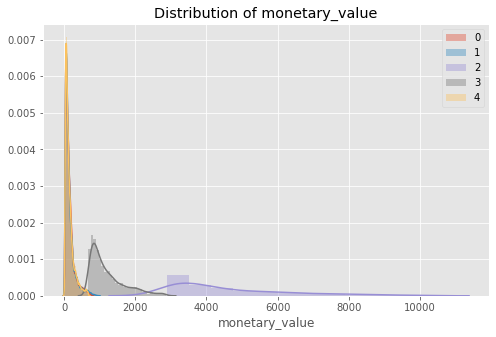

In [322]:
colnames = ['recency','frequency','monetary_value']
segments=[0,1,2,3,4]

for col in colnames:
    fig, ax = plt.subplots(figsize=(8,5))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['cluster']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

In [332]:
rfm = (df_cluster.groupby('cluster')['recency','frequency','monetary_value'].mean().reset_index()).round(2)
rfm

<ipython-input-332-526ded6ad2db>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



cluster  recency  frequency  monetary_value
0        0    86.07       1.13          147.45
1        1   453.92       1.17          149.48
2        2   235.08       4.45         4549.47
3        3   228.30       2.18         1204.52
4        4   253.38       1.14          142.79

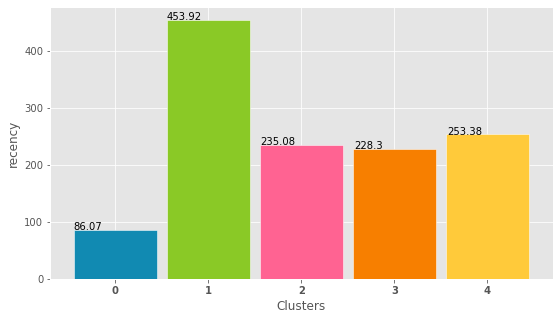

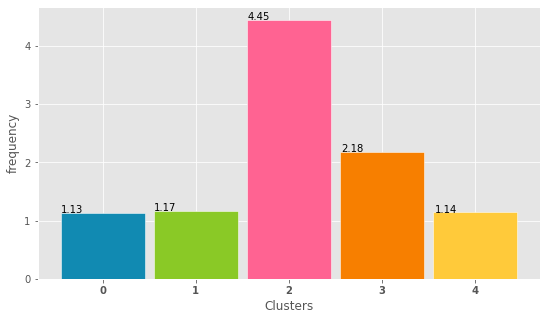

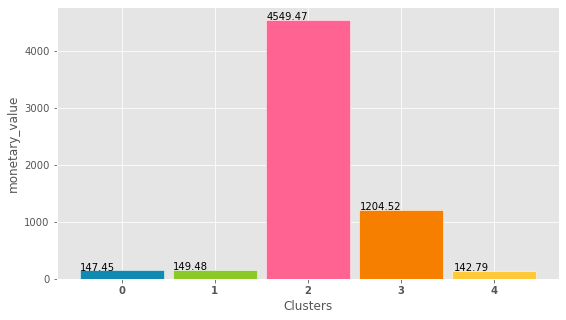

In [335]:
colnames = ['recency','frequency','monetary_value']

for col in colnames:
    colors = ['#118ab2', '#8ac926','#ff6392','#f77f00','#ffca3a']
    fig, ax = plt.subplots(figsize=(9,5))
    ax = rfm[col].plot(kind='bar',width=0.9,color=colors, edgecolor='white')
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
    plt.xlabel('Clusters')
    plt.ylabel('%s' % col)
    plt.xticks(fontweight='bold', rotation='horizontal')
    plt.show()

### Payment

In [339]:
pay = df_cluster.groupby('cluster')['payment_type'].value_counts()
pay = pay.unstack()
pay.reset_index()

payment_type  cluster  boleto  credit  debit  multiple  voucher
0                   0    6527   26748    839       693      509
1                   1    4845   16424    202       616      435
2                   2      93     217      2         6        1
3                   3     667    2816     47        63       23
4                   4    7140   26249    399       808      543

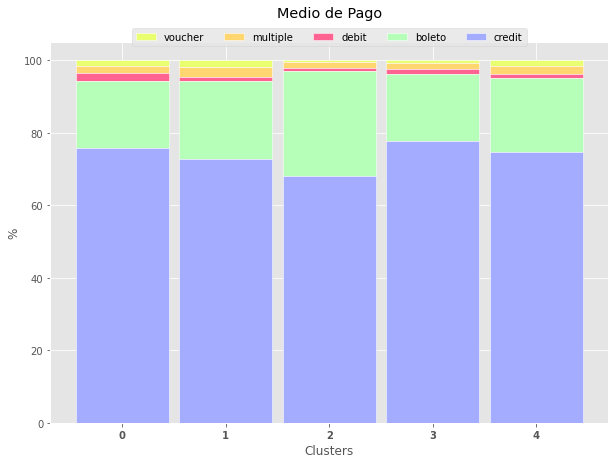

In [340]:
clusters = (['0','1','2','3','4'])
boleto = np.array(pay['boleto'].unique())
credit = np.array(pay['credit'].unique())
debit = np.array(pay['debit'].unique())
multiple = np.array(pay['multiple'].unique())
voucher = np.array(pay['voucher'].unique())


total = boleto+credit+debit+multiple+voucher
proportion_voucher = np.true_divide(voucher,total)*100
proportion_multiple = np.true_divide(multiple,total)*100
proportion_debit = np.true_divide(debit,total)*100
proportion_boleto = np.true_divide(boleto,total)*100
proportion_credit = np.true_divide(credit,total)*100


colors = ['#a3acff', '#b5ffb9','#ff6392','#FFD670','#E9FF70']

# The position of the bars on the x-axis
r = range(len(clusters))

barWidth = 0.9
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, proportion_voucher, bottom=proportion_multiple+proportion_debit+proportion_boleto+proportion_credit, color=colors[4], edgecolor='white', width=barWidth, label="voucher")
ax2 = plt.bar(r, proportion_multiple, bottom=proportion_debit+proportion_boleto+proportion_credit, color=colors[3], edgecolor='white', width=barWidth, label='multiple')
ax3 = plt.bar(r, proportion_debit, bottom = proportion_boleto+proportion_credit, color=colors[2], edgecolor='white', width=barWidth, label='debit')
ax4 = plt.bar(r, proportion_boleto, bottom = proportion_credit, color=colors[1], edgecolor='white', width=barWidth, label='boleto')
ax5 = plt.bar(r, proportion_credit , color=colors[0], edgecolor='white', width=barWidth, label='credit')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True)
plt.xticks(r, clusters, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('%')
plt.title('Medio de Pago', pad=25)
plt.show()

#### Gasto Médio

In [341]:
df_cluster.groupby('cluster')['gasto_medio'].mean()

cluster
0     131.092007
1     130.723906
2    1440.726614
3     761.287459
4     126.686946
Name: gasto_medio, dtype: float64

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

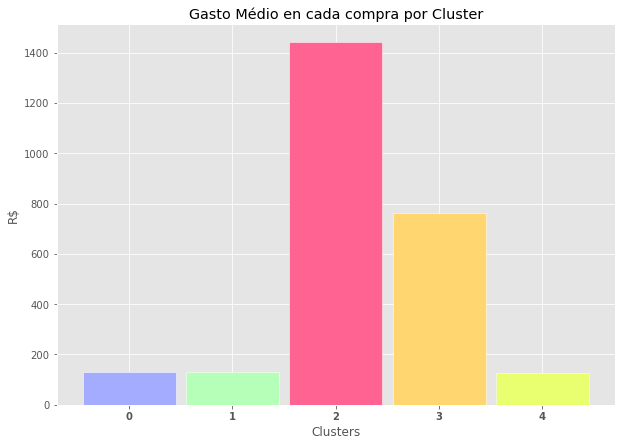

In [343]:
colors = ['#a3acff', '#b5ffb9','#ff6392','#FFD670','#E9FF70']
plt.figure(figsize=(10,7))
df_cluster.groupby('cluster')['gasto_medio'].mean().plot(kind='bar',width=0.9,color=colors, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
plt.xlabel('Clusters')
plt.ylabel('R$')
plt.title('Gasto Médio en cada compra por Cluster')
plt.xticks(fontweight='bold', rotation='horizontal')

#### Envio

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

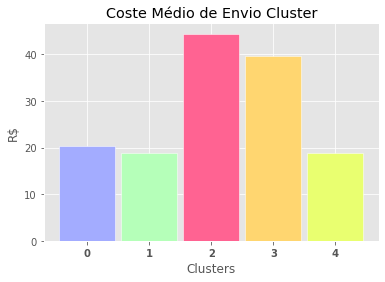

In [336]:
colors = ['#a3acff', '#b5ffb9','#ff6392','#FFD670','#E9FF70']
df_cluster.groupby('cluster')['media_frete'].mean().plot(kind='bar',width=0.9,color=colors, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
plt.xlabel('Clusters')
plt.ylabel('R$')
plt.title('Coste Médio de Envio Cluster')
plt.xticks(fontweight='bold', rotation='horizontal')

#### Region

In [347]:
region = df_cluster.groupby('cluster')['customer_regiao'].value_counts().unstack().reset_index()
region

customer_regiao  cluster  Centro-Oeste  Nordeste  Norte  Sudeste   Sul
0                      0          2004      3066    517    25030  4699
1                      1          1237      2285    505    14995  3500
2                      2            28        54      6      177    54
3                      3           239       462    129     2259   527
4                      4          2115      3317    642    24073  4992

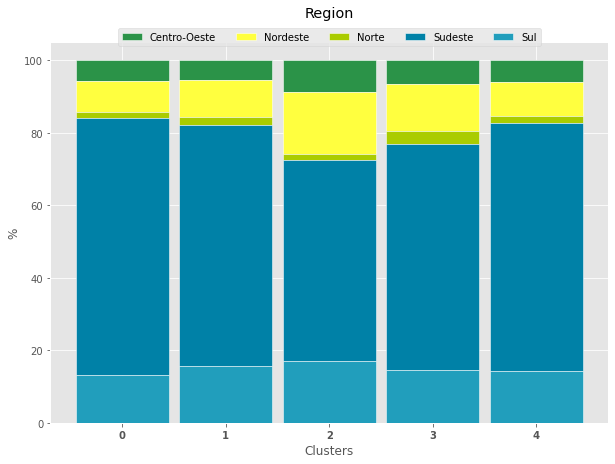

In [348]:
clusters = (['0','1','2','3','4'])
centro = np.array(region['Centro-Oeste'].unique())
nordeste = np.array(region['Nordeste'].unique())
norte = np.array(region['Norte'].unique())
sudeste = np.array(region['Sudeste'].unique())
sul = np.array(region['Sul'].unique())


total = centro+nordeste+norte+sudeste+sul
proportion_centro = np.true_divide(centro,total)*100
proportion_nordeste = np.true_divide(nordeste,total)*100
proportion_norte = np.true_divide(norte,total)*100
proportion_sudeste = np.true_divide(sudeste,total)*100
proportion_sul = np.true_divide(sul,total)*100

colors = ['#2b9348', '#ffff3f','#aacc00','#0081a7','#219ebc']

# The position of the bars on the x-axis
r = range(len(clusters))

barWidth = 0.9
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, proportion_centro, bottom=proportion_nordeste+proportion_norte+proportion_sudeste+proportion_sul, color=colors[0], edgecolor='white', width=barWidth, label="Centro-Oeste")
ax2 = plt.bar(r, proportion_nordeste, bottom=proportion_norte+proportion_sudeste+proportion_sul, color=colors[1], edgecolor='white', width=barWidth, label='Nordeste')
ax3 = plt.bar(r, proportion_norte, bottom = proportion_sudeste+proportion_sul, color=colors[2], edgecolor='white', width=barWidth, label='Norte')
ax3 = plt.bar(r, proportion_sudeste,  bottom = proportion_sul, color=colors[3], edgecolor='white', width=barWidth, label='Sudeste')
ax4 = plt.bar(r, proportion_sul, color=colors[4], edgecolor='white', width=barWidth, label='Sul')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True)
plt.xticks(r, clusters, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('%')
plt.title('Region', pad=25)
plt.show()

### City

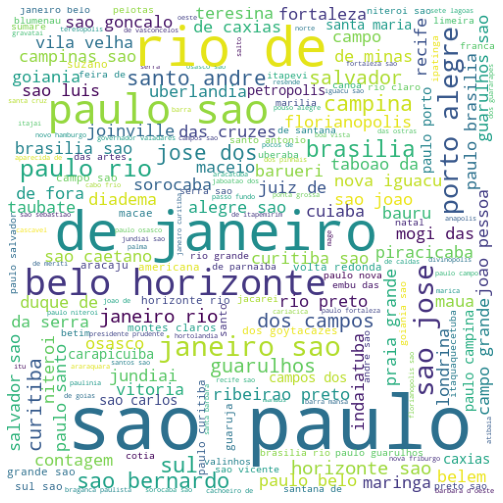

In [387]:
# Create the wordcloud object
plt.figure(figsize=(15,9))

text = ' '.join(df_cluster['customer_city'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)
 
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Ciudad

In [367]:
cluster=[0,1,2,3,4]
for c in cluster:
    city = df_cluster.loc[df_cluster['cluster']==c]
    print('------Cluster %s ------' % c )
    print(city['customer_city'].value_counts(normalize = True)[:5])
    print('  ')

------Cluster 0 ------
sao paulo         0.176747
rio de janeiro    0.062550
belo horizonte    0.028741
brasilia          0.023021
curitiba          0.016055
Name: customer_city, dtype: float64
  
------Cluster 1 ------
sao paulo         0.138087
rio de janeiro    0.072507
belo horizonte    0.024865
brasilia          0.018426
porto alegre      0.016073
Name: customer_city, dtype: float64
  
------Cluster 2 ------
sao paulo         0.141066
rio de janeiro    0.075235
brasilia          0.031348
salvador          0.028213
porto alegre      0.028213
Name: customer_city, dtype: float64
  
------Cluster 3 ------
sao paulo         0.131361
rio de janeiro    0.076051
belo horizonte    0.023230
brasilia          0.022677
curitiba          0.017699
Name: customer_city, dtype: float64
  
------Cluster 4 ------
sao paulo         0.149207
rio de janeiro    0.072512
belo horizonte    0.029170
brasilia          0.021628
curitiba          0.015168
Name: customer_city, dtype: float64
  


In [366]:
cluster=[0,1,2,3,4]
for c in cluster:
    city = df_cluster.loc[df_cluster['cluster']==c]
    print('------Cluster %s ------' % c )
    print(city['customer_state'].value_counts(normalize = True)[:5])
    print('  ')

------Cluster 0 ------
SP    0.460160
RJ    0.117539
MG    0.111791
PR    0.050487
RS    0.050147
Name: customer_state, dtype: float64
  
------Cluster 1 ------
SP    0.390463
RJ    0.135024
MG    0.118418
RS    0.063449
PR    0.052837
Name: customer_state, dtype: float64
  
------Cluster 2 ------
SP    0.313480
RJ    0.122257
MG    0.109718
BA    0.068966
PR    0.062696
Name: customer_state, dtype: float64
  
------Cluster 3 ------
SP    0.354812
RJ    0.139381
MG    0.111449
RS    0.055033
PR    0.052821
Name: customer_state, dtype: float64
  
------Cluster 4 ------
SP    0.405561
RJ    0.136117
MG    0.121830
RS    0.054242
PR    0.049005
Name: customer_state, dtype: float64
  


#### Periodo de compra

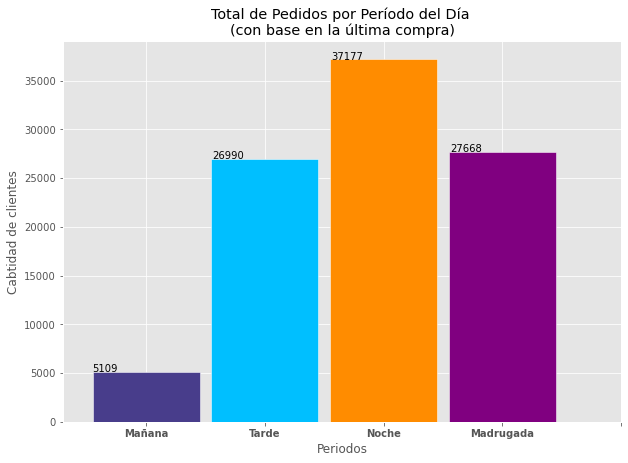

In [290]:
r = range(len(clusters))
plt.figure(figsize=(10,7))
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']

ax = df['order_purchase_time_day'].value_counts().sort_index().plot(kind='bar',width=0.9,color=day_color_list, edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))

label = ['Madrugada','Tarde']
plt.xlabel('Periodos')
plt.ylabel('Cabtidad de clientes')
plt.title('Total de Pedidos por Período del Día \n(con base en la última compra)')
plt.xticks(r, df['order_purchase_time_day'].unique(), fontweight='bold', rotation='horizontal')

plt.show()

#### Período

In [289]:
periodo = df_cluster.groupby('cluster')['order_purchase_time_day'].value_counts()
periodo = periodo.unstack()
periodo.reset_index()

order_purchase_time_day  cluster  Madrugada  Mañana  Noche  Tarde
0                              0       2045    9657  10118  13308
1                              1       1698   10102   9967  13570
2                              2       1179    6116   6577   8637
3                              3          7     107     63    142
4                              4        178    1001    937   1503

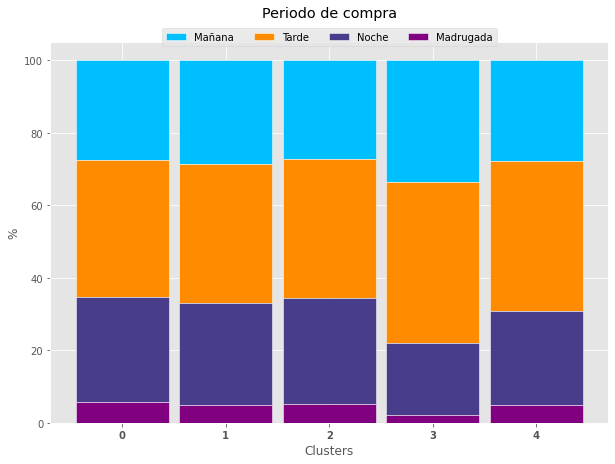

In [296]:
clusters = (['0','1','2','3','4'])
manana = np.array(periodo['Mañana'].unique())
tarde = np.array(periodo['Tarde'].unique())
noche = np.array(periodo['Noche'].unique())
madrugada = np.array(periodo['Madrugada'].unique())

total = manana+tarde+noche+madrugada
proportion_manana = np.true_divide(manana,total)*100
proportion_tarde = np.true_divide(tarde,total)*100
proportion_noche = np.true_divide(noche,total)*100
proportion_madrugada = np.true_divide(madrugada,total)*100

colors = ['deepskyblue','darkorange',  'darkslateblue', 'purple']

# The position of the bars on the x-axis
r = range(len(clusters))

barWidth = 0.9
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, proportion_manana, bottom=proportion_tarde+proportion_noche+proportion_madrugada, color=colors[0], edgecolor='white', width=barWidth, label="Mañana")
ax2 = plt.bar(r, proportion_tarde, bottom=proportion_noche+proportion_madrugada, color=colors[1], edgecolor='white', width=barWidth, label='Tarde')
ax3 = plt.bar(r, proportion_noche, bottom = proportion_madrugada, color=colors[2], edgecolor='white', width=barWidth, label='Noche')
ax4 = plt.bar(r, proportion_madrugada, color=colors[3], edgecolor='white', width=barWidth, label='Madrugada')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True)
plt.xticks(r, clusters, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('%')
plt.title('Periodo de compra', pad=25)
plt.show()

#### Product Category

Para describir las categorias de productos más consumidas por cada clusters, utilizaremos el dataset general all_data, por que esas caracteristicas son muy difíciles de ser agrupadas por clientes/cluster.

In [482]:
product = all_data[['customer_id','product_category_name']]
cluster = df_cluster[['customer_id','cluster']]
product_cluster = pd.merge(product, cluster[['customer_id','cluster']], on='customer_id')


In [371]:
cluster=[0,1,2,3,4]
for c in cluster:
    product = product_cluster.loc[product_cluster['cluster']==c]
    print('------Cluster %s ------' % c )
    print(product['product_category_name'].value_counts(normalize = True)[:5])
    print('  ')

------Cluster 0 ------
beleza_saude             0.105429
cama_mesa_banho          0.096764
utilidades_domesticas    0.073490
esporte_lazer            0.070419
relogios_presentes       0.068247
Name: product_category_name, dtype: float64
  
------Cluster 1 ------
cama_mesa_banho          0.109941
moveis_decoracao         0.088688
esporte_lazer            0.080694
beleza_saude             0.074973
utilidades_domesticas    0.067700
Name: product_category_name, dtype: float64
  
------Cluster 2 ------
informatica_acessorios    0.152709
moveis_escritorio         0.134412
utilidades_domesticas     0.111893
moveis_decoracao          0.111189
cama_mesa_banho           0.073892
Name: product_category_name, dtype: float64
  
------Cluster 3 ------
moveis_decoracao          0.111280
cama_mesa_banho           0.110137
informatica_acessorios    0.095910
esporte_lazer             0.065549
relogios_presentes        0.061865
Name: product_category_name, dtype: float64
  
------Cluster 4 ------
cama_me

In [483]:
#Agrupado de categorias
alimentos_bebidas = ['alimentos', 'bebidas', 'alimentos_bebidas']
artesanato =['artes_e_artesanato',  'artes']
automotivo = ['automotivo']
bebê_criança = ['bebes', 'brinquedos']
beleza_saúde_perfumaria = ['beleza_saude', 'perfumaria', 'fraldas_higiene']
cama_mesa_banho = ['cama_mesa_banho', 'casa_conforto_2', 'casa_conforto']
casa_construção_jardim = ['construcao_ferramentas_seguranca','construcao_ferramentas_ferramentas', 'construcao_ferramentas_jardim', 'construcao_ferramentas_iluminacao', 'sinalizacao_e_seguranca', 'construcao_ferramentas_construcao',  'casa_construcao',  'flores', 'ferramentas_jardim', 'climatizacao']
eletrodomésticos_utilidades_domésticas = ['eletrodomesticos', 'eletrodomesticos_2', 'portateis_casa_forno_e_cafe', 'la_cuisine', 'utilidades_domesticas', 'eletroportateis']
esporte_lazer = ['esporte_lazer']
indústria_negócios = ['agro_industria_e_comercio', 'industria_comercio_e_negocios']
informática_eltrônicos_games = ['informatica_acessorios', 'consoles_games','eletronicos','tablets_impressao_imagem','pcs']
livros_papelaria = ['livros_importados', 'livros_tecnicos', 'livros_interesse_geral', 'papelaria']
market_place = ['market_place']
móveis_decoração = ['moveis_decoracao', 'moveis_cozinha_area_de_servico_jantar_e_jardim', 'moveis_quarto', 'moveis_sala', 'moveis_escritorio', 'moveis_colchao_e_estofado', 'artigos_de_natal', 'artigos_de_festas']
música_vídeo = ['instrumentos_musicais', 'cds_dvds_musicais', 'musica',  'audio', 'dvds_blu_ray', 'cine_foto']
petshop = ['pet_shop']
presentes_coolstuff = ['relogios_presentes',  'cool_stuff']
roupas_acessórios_malas = ['fashion_bolsas_e_acessorios', 'fashion_calcados', 'fashion_roupa_masculina', 'fashion_roupa_feminina', 'fashion_esporte', 'fashion_roupa_infanto_juvenil', 'fashion_underwear_e_moda_praia', 'malas_acessorios']
seguros_serviços = ['seguros_e_servicos']
telefonia = ['telefonia', 'telefonia_fixa']


In [485]:
product_cluster['categorias'] =''
product_cluster.loc[product_cluster['product_category_name'].isin(alimentos_bebidas), 'categorias'  ] = 'alimentos_bebidas'
product_cluster.loc[product_cluster['product_category_name'].isin(artesanato), 'categorias'] = 'artesanato'
product_cluster.loc[product_cluster['product_category_name'].isin(automotivo), 'categorias'] = 'automotivo'
product_cluster.loc[product_cluster['product_category_name'].isin(bebê_criança), 'categorias'] = 'bebê_criança'
product_cluster.loc[product_cluster['product_category_name'].isin(beleza_saúde_perfumaria), 'categorias'] = 'beleza_saúde_perfumaria'
product_cluster.loc[product_cluster['product_category_name'].isin(cama_mesa_banho), 'categorias'] = 'cama_mesa_banho'
product_cluster.loc[product_cluster['product_category_name'].isin(casa_construção_jardim), 'categorias'] = 'casa_construção_jardim'
product_cluster.loc[product_cluster['product_category_name'].isin(eletrodomésticos_utilidades_domésticas), 'categorias'] = 'eletrodomésticos_utilidades_domésticas'
product_cluster.loc[product_cluster['product_category_name'].isin(esporte_lazer), 'categorias'] = 'esporte_lazer'
product_cluster.loc[product_cluster['product_category_name'].isin(indústria_negócios), 'categorias'] = 'indústria_negócios'
product_cluster.loc[product_cluster['product_category_name'].isin(informática_eltrônicos_games), 'categorias'] = 'informática_eltrônicos_games'
product_cluster.loc[product_cluster['product_category_name'].isin(livros_papelaria), 'categorias'] = 'livros_papelaria'
product_cluster.loc[product_cluster['product_category_name'].isin(market_place), 'categorias'] = 'market_place'
product_cluster.loc[product_cluster['product_category_name'].isin(móveis_decoração), 'categorias'] = 'móveis_decoração'
product_cluster.loc[product_cluster['product_category_name'].isin(música_vídeo), 'categorias'] = 'música_vídeo'
product_cluster.loc[product_cluster['product_category_name'].isin(petshop), 'categorias'] = 'petshop'
product_cluster.loc[product_cluster['product_category_name'].isin(presentes_coolstuff), 'categorias'] = 'presentes_coolstuff'
product_cluster.loc[product_cluster['product_category_name'].isin(roupas_acessórios_malas), 'categorias'] = 'roupas_acessórios_malas'
product_cluster.loc[product_cluster['product_category_name'].isin(seguros_serviços), 'categorias'] = 'seguros_serviços'
product_cluster.loc[product_cluster['product_category_name'].isin(telefonia), 'categorias'] = 'telefonia'

In [486]:
product_cluster

customer_id  product_category_name  cluster  \
0       9ef432eb6251297304e76186b10a928d  utilidades_domesticas        4   
1       9ef432eb6251297304e76186b10a928d  utilidades_domesticas        4   
2       9ef432eb6251297304e76186b10a928d  utilidades_domesticas        4   
3       a20e8105f23924cd00833fd87daa0831  utilidades_domesticas        1   
4       26c7ac168e1433912a51b924fbd34d34  utilidades_domesticas        1   
...                                  ...                    ...      ...   
115879  e42e2e8642f9c09100b6667e321c2811      livros_importados        0   
115880  0cbd2df3d6e9d8b1eaf5cfefc44886bc      livros_importados        0   
115881  c4d135422be0d4333f506acde8af9419      livros_importados        0   
115882  65d9213dfa004c17dc126503e106e4a3      livros_importados        3   
115883  ff95df9a387c8d032a2ca6887cf77236      livros_importados        1   

                                    categorias  
0       eletrodomésticos_utilidades_domésticas  
1       eletrodomésticos_utilidades_domésticas  
2       eletrodomésticos_utilidades_domésticas  
3       eletrodomésticos_utilidades_domésticas  
4       eletrodomésticos_utilidades_domésticas  
...                                        ...  
115879                        livros_papelaria  
115880                        livros_papelaria  
115881                        livros_papelaria  
115882                        livros_papelaria  
115883                        livros_papelaria  

[115884 rows x 4 columns]

In [489]:
product_cluster['categorias'].value_counts(normalize = True)

beleza_saúde_perfumaria                   0.117108
cama_mesa_banho                           0.107599
informática_eltrônicos_games              0.107021
móveis_decoração                          0.100670
presentes_coolstuff                       0.087907
eletrodomésticos_utilidades_domésticas    0.079813
esporte_lazer                             0.077543
casa_construção_jardim                    0.064694
bebê_criança                              0.064124
telefonia                                 0.042845
automotivo                                0.037693
roupas_acessórios_malas                   0.034310
livros_papelaria                          0.030392
petshop                                   0.017474
música_vídeo                              0.011192
alimentos_bebidas                         0.010321
indústria_negócios                        0.004435
market_place                              0.002744
artesanato                                0.002097
seguros_serviços               

In [541]:
cluster=[0,1,2,3,4]
for c in cluster:
    product = product_cluster.loc[product_cluster['cluster']==c]
    print('------Cluster %s ------' % c )
    print(product['categorias'].value_counts(normalize = True)[:6])
    print('  ')

------Cluster 0 ------
beleza_saúde_perfumaria                   0.133546
cama_mesa_banho                           0.100010
informática_eltrônicos_games              0.097488
eletrodomésticos_utilidades_domésticas    0.093218
presentes_coolstuff                       0.090221
móveis_decoração                          0.083829
Name: categorias, dtype: float64
  
------Cluster 1 ------
cama_mesa_banho                           0.116836
móveis_decoração                          0.115245
beleza_saúde_perfumaria                   0.109600
informática_eltrônicos_games              0.091112
presentes_coolstuff                       0.085808
eletrodomésticos_utilidades_domésticas    0.085467
Name: categorias, dtype: float64
  
------Cluster 2 ------
móveis_decoração                          0.272343
informática_eltrônicos_games              0.194229
eletrodomésticos_utilidades_domésticas    0.121042
casa_construção_jardim                    0.088670
cama_mesa_banho                           0

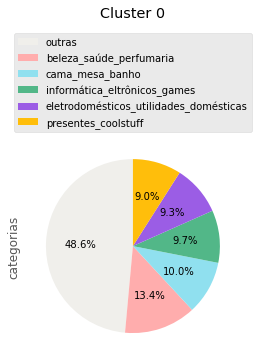

In [602]:
prod = product_cluster.groupby('cluster')['categorias'].value_counts().unstack().reset_index()
product0 = product_cluster.loc[product_cluster['cluster']==0]
product0.loc[product0['categorias'].isin(product0.categorias.value_counts()[:5].index)==False, 'categorias'  ] = 'outras'

legend = product0.categorias.value_counts().index
colors = ['#f0efeb','#ffadad', '#90e0ef','#52b788','#9b5de5', '#ffbe0b']
top5 = product0.categorias.value_counts(normalize=True)
ax = top5.plot.pie(colors=colors, autopct='%1.1f%%', startangle=90, labeldistance=None)
plt.legend(legend, loc='lower center', bbox_to_anchor=(.5,1),ncol=1)
plt.title('Cluster 0', pad=120)
plt.show()

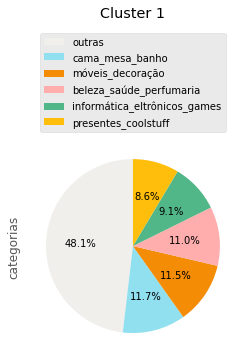

In [599]:
prod = product_cluster.groupby('cluster')['categorias'].value_counts().unstack().reset_index()
product0 = product_cluster.loc[product_cluster['cluster']==1]
product0.loc[product0['categorias'].isin(product0.categorias.value_counts()[:5].index)==False, 'categorias'  ] = 'outras'

legend = product0.categorias.value_counts().index
colors = ['#f0efeb','#90e0ef', '#f48c06','#ffadad','#52b788', '#ffbe0b']
top5 = product0.categorias.value_counts(normalize=True)
ax = top5.plot.pie(colors=colors, autopct='%1.1f%%', startangle=90, labeldistance=None)
plt.legend(legend, loc='lower center', bbox_to_anchor=(.5,1),ncol=1)
plt.title('Cluster 1', pad=120)
plt.show()

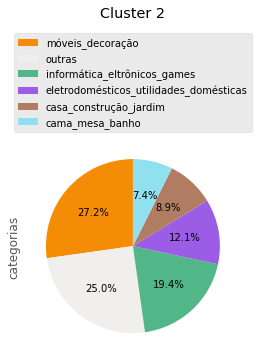

In [597]:
prod = product_cluster.groupby('cluster')['categorias'].value_counts().unstack().reset_index()
product0 = product_cluster.loc[product_cluster['cluster']==2]
product0.loc[product0['categorias'].isin(product0.categorias.value_counts()[:5].index)==False, 'categorias'  ] = 'outras'

legend = product0.categorias.value_counts().index
colors = ['#f48c06','#f0efeb', '#52b788','#9b5de5','#b07d62', '#90e0ef']
top5 = product0.categorias.value_counts(normalize=True)
ax = top5.plot.pie(colors=colors, autopct='%1.1f%%', startangle=90, labeldistance=None)
plt.legend(legend, loc='lower center', bbox_to_anchor=(.5,1),ncol=1)
plt.title('Cluster 2', pad=120)
plt.show()

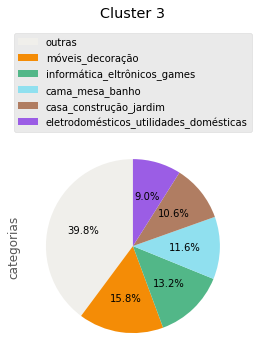

In [595]:
prod = product_cluster.groupby('cluster')['categorias'].value_counts().unstack().reset_index()
product0 = product_cluster.loc[product_cluster['cluster']==3]
product0.loc[product0['categorias'].isin(product0.categorias.value_counts()[:5].index)==False, 'categorias'  ] = 'outras'

legend = product0.categorias.value_counts().index
colors = ['#f0efeb','#f48c06', '#52b788','#90e0ef','#b07d62', '#9b5de5']
top5 = product0.categorias.value_counts(normalize=True)
ax = top5.plot.pie(colors=colors, autopct='%1.1f%%', startangle=90, labeldistance=None)
plt.legend(legend, loc='lower center', bbox_to_anchor=(.5,1),ncol=1)
plt.title('Cluster 3', pad=120)
plt.show()

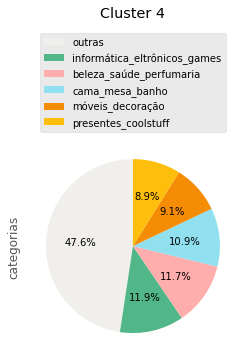

In [588]:
prod = product_cluster.groupby('cluster')['categorias'].value_counts().unstack().reset_index()
product0 = product_cluster.loc[product_cluster['cluster']==4]
product0.loc[product0['categorias'].isin(product0.categorias.value_counts()[:5].index)==False, 'categorias'  ] = 'outras'

legend = product0.categorias.value_counts().index
colors = ['#f0efeb','#52b788','#ffadad','#90e0ef','#f48c06', '#ffbe0b']
top5 = product0.categorias.value_counts(normalize=True)
ax = top5.plot.pie(colors=colors, autopct='%1.1f%%', startangle=90, labeldistance=None)
plt.legend(legend, loc='lower center', bbox_to_anchor=(.5,1),ncol=1)
plt.title('Cluster 4', pad=120)
plt.show()

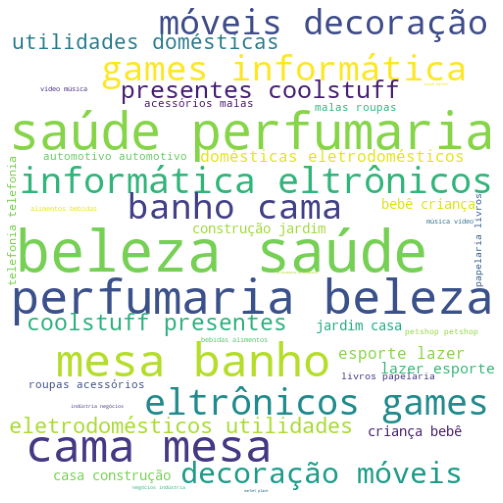

In [603]:
plt.figure(figsize=(15,9))

text = ' '.join(product_cluster['categorias'].str.replace('_',' '))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color ='white').generate(text)
 
# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()